In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
def coth(a):
    if a>0: return (1+tf.math.exp(-2*a))/(1-tf.math.exp(-2*a))
    if a<0: return (tf.math.exp(2*a)+1)/(tf.math.exp(2*a)-1)
    if a==0: return 0

def tanh(a):
    if a>0: return (1-tf.math.exp(-2*a))/(1+tf.math.exp(-2*a))
    if a<0: return (tf.math.exp(2*a)-1)/(tf.math.exp(2*a)+1)
    if a==0: return 0

In [3]:
data=10000
batch=100
set=100
layer=10
n_ini=1.0
n_fin=0.1
dn=-0.1
c_reg1=0.015
c_reg2=0.0001
d=2

m^2= <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.8836963280105696>
lam= <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.493545709342028>
alpha= <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=-0.2414018197387896>
beta= <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=-0.1105812272927833>
<tf.Variable 'Variable:0' shape=(10,) dtype=float64, numpy=
array([ 2.03671808,  0.80654329,  1.10247186,  2.14648697,  2.22119686,
        3.55956813,  1.24402675, -0.29238147,  2.12317158,  2.36293847])>


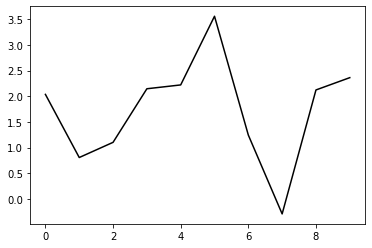

In [4]:
h=tf.zeros(layer)
h_in=[]
for i in range (layer):
    h_inn=np.float64(np.random.normal(2, 1))
    h_in.append(h_inn)
h=tf.Variable(h_in)
m2=tf.Variable(np.float64(np.random.normal(2, 1)))
lam=tf.Variable(np.float64(np.random.normal(1, 1)))
alpha=tf.Variable(np.float64(np.random.uniform(-0.5, 0.5)))
beta=tf.Variable(np.float64(np.random.uniform(-0.5, 0.5)))
#m2=tf.constant(np.float64(5.6))
#lam=tf.constant(np.float64(0.61))
#alpha=tf.constant(np.float64(1.444635))
#beta=tf.constant(np.float64(0.00615))
print("m^2=", m2)
print("lam=", lam)
print("alpha=", alpha)
print("beta=", beta)
print(h)
plt.plot(h.numpy(), 'k-')
plt.show()

In [5]:
def F_func(m, la, a,b):
    return 2*b/n_fin-m*a-la*(a**3)

def t_func(a):
    return 0.5*(tf.math.tanh(100*(a-0.1))-tf.math.tanh(100*(a+0.1))+2)

In [6]:
x=[i*0.2 for i in range (30)]
y=[0.0, 0.018, 0.035, 0.053, 0.0715, 0.0895, 0.107, 0.125, 0.146, 0.1665, 0.1875, 0.2085, 0.229, 0.25, 0.265, 0.281, 0.296, 0.3115, 0.3275, 0.343, 0.3565, 0.385, 0.4375, 0.5, 0.6, 0.675, 0.735, 0.815, 0.865, 0.885]
y[:]=[2*v for v in y]
fp1 = np.polyfit(x, y, 15)
print(fp1)

[ 1.59046394e-05 -6.81729682e-04  1.31412795e-02 -1.50525136e-01
  1.14052774e+00 -6.02241647e+00  2.27455168e+01 -6.20704699e+01
  1.22166922e+02 -1.71187074e+02  1.66428955e+02 -1.07461552e+02
  4.28229887e+01 -9.20544914e+00  9.55260239e-01 -1.30911492e-04]


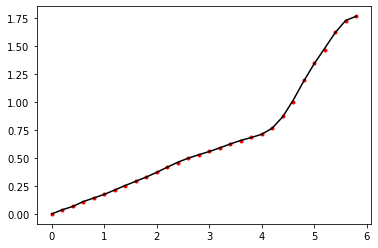

In [7]:
def f(x):
    y=0
    for i in range (16):
        y=y+fp1[i]*x**(15-i)
    return y
yy=[f(i*0.2) for i in range (30)]
plt.plot(x, y, 'r.')
plt.plot(x, yy, 'k-')
plt.show()

In [8]:
def NN_func_p(f):
    Positive=[]
    append=Positive.append
    while len(Positive)<batch:
        H=np.random.uniform(0.0, 6.0)
        M=np.random.uniform(0.0, 2.0)
        noise=np.abs(np.random.normal(0, 0.1))
        if np.abs(M-f(H))<=noise: append([H, M])
        else: continue
    return Positive
def NN_func_n(f):
    Negative=[]
    append=Negative.append
    while len(Negative)<batch:
        H=np.random.uniform(0.0, 6.0)
        M=np.random.uniform(0.0, 2.0)
        noise=np.abs(np.random.normal(0, 0.1))
        if np.abs(M-f(H))>noise: append([H, M])
        else: continue
    return Negative

In [10]:
Positive=[]
Negative=[]
for i in range (set):
    Positive.insert(i, NN_func_p(f))
    Negative.insert(i, NN_func_n(f))

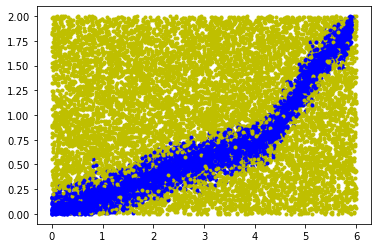

In [11]:
x_data1=[]
y_data1=[]
x_data2=[]
y_data2=[]
for i in range (set):
    x_data1.insert(i, [v[0] for v in Positive[i]])
    y_data1.insert(i, [v[1] for v in Positive[i]])
    x_data2.insert(i, [v[0] for v in Negative[i]])
    y_data2.insert(i, [v[1] for v in Negative[i]])
    plt.plot(x_data2[i], y_data2[i], 'y.')
    plt.plot(x_data1[i], y_data1[i], 'b.')
plt.show()

In [12]:
def Dfunc(hh, m):
    D=tf.math.sqrt(tf.math.abs(1+4*m/(hh[0]**2)))
    return D

In [13]:
def LP2(hh, m, la, alpha, beta, HH, MM):
    D=Dfunc(hh, m)
    phi=alpha*HH+beta*MM
    pi=(d/2)*(D-1)*alpha*HH+(d/2)*(-D-1)*beta*MM
    for j in range (layer-1):
        phi1=phi+dn*pi
        pi1 =phi*m*dn+(1-dn*hh[j])*pi+dn*la*(phi1**3)
        phi=phi1
        pi=pi1
    return phi, pi
def NN_func_01(hh, m, la, alpha, beta, list_hr):
    PP=[]
    NN=[]
    H=np.array(list_hr)[:, 0]
    M=np.array(list_hr)[:, 1]
    F=np.array(tf.math.abs(LP2(hh, m, la, alpha, beta, H, M)[1]))
    for i in range (len(H[F<0.1])):
        PP.append([H[F<0.1][i], M[F<0.1][i]])
    for i in range (len(H[F>=0.1])):
        NN.append([H[F>=0.1][i], M[F>=0.1][i]])
    return PP, NN

In [14]:
Positive0=[]
Positive1=[]
Negative0=[]
Negative1=[]
for i in range (set):
    Positive0.insert(i, NN_func_01(h, m2, lam, alpha, beta, Positive[i])[0])
    Positive1.insert(i, NN_func_01(h, m2, lam, alpha, beta, Positive[i])[1])
    Negative0.insert(i, NN_func_01(h, m2, lam, alpha, beta, Negative[i])[0])
    Negative1.insert(i, NN_func_01(h, m2, lam, alpha, beta, Negative[i])[1])

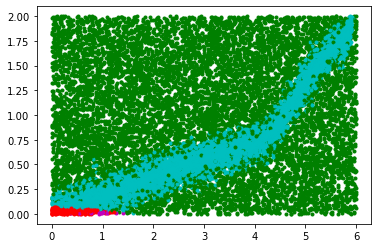

In [15]:
x_data1=[]
y_data1=[]
x_data2=[]
y_data2=[]
x_data3=[]
y_data3=[]
x_data4=[]
y_data4=[]
for i in range (set):
    x_data1.insert(i, [v[0] for v in Positive0[i]])
    y_data1.insert(i, [v[1] for v in Positive0[i]])
    x_data2.insert(i, [v[0] for v in Positive1[i]])
    y_data2.insert(i, [v[1] for v in Positive1[i]])
    x_data3.insert(i, [v[0] for v in Negative0[i]])
    y_data3.insert(i, [v[1] for v in Negative0[i]])
    x_data4.insert(i, [v[0] for v in Negative1[i]])
    y_data4.insert(i, [v[1] for v in Negative1[i]])
    plt.plot(x_data4[i], y_data4[i], 'g.')
    plt.plot(x_data2[i], y_data2[i], 'c.')
    plt.plot(x_data1[i], y_data1[i], 'r.')
    plt.plot(x_data3[i], y_data3[i], 'm.')
plt.show()

# Error function

$E=\sum_{data} \left\vert y(\bar{x}^{(1)}) - \bar{y} \right\vert+E_{reg}(W)$
, $E_{reg}=c_{reg}^{(1)}\sum_{n=1}^{N-1}(\eta^{(n)})^{4}(h(\eta^{(n+1)})-h(\eta^{(n)}))^{2}+c_{reg}^{(2)}(h(\eta^{(N)})-1/\eta^{(N)})^{2}$

In [16]:
def Error_func(hh, m, la, alpha, beta, list1, list2):
    H0=np.array([v[0] for v in list1])
    M0=np.array([v[1] for v in list1])
    H1=np.array([v[0] for v in list2])
    M1=np.array([v[1] for v in list2])
    H_0, M_0=LP2(hh, m, la, alpha, beta, H0, M0)
    H_1, M_1=LP2(hh, m, la, alpha, beta, H1, M1)
    PPlist=t_func(M_0)
    NNlist=t_func(M_1)
    sum_p=sum(PPlist)/batch
    sum_n=(batch-sum(NNlist))/batch

    inside=0
    for k in range (layer-1):
        second=((n_ini+k*dn)**4)*((hh[k+1]-hh[k])**2)
        inside=inside+second
    E_reg1=c_reg1*inside
    E_reg2=c_reg2*((hh[layer-1]-1/n_fin)**2)
    return sum_n+sum_p+E_reg1+E_reg2

In [17]:
for i in range (set):
    print(Error_func(h, m2, lam, alpha, beta, Positive[i], Negative[i]))

tf.Tensor(1.0159422769695088, shape=(), dtype=float64)
tf.Tensor(1.0173324027468336, shape=(), dtype=float64)
tf.Tensor(0.9818834993737374, shape=(), dtype=float64)
tf.Tensor(1.0285239209842882, shape=(), dtype=float64)
tf.Tensor(1.0077386436344449, shape=(), dtype=float64)
tf.Tensor(0.9854734868354283, shape=(), dtype=float64)
tf.Tensor(1.0220456104711142, shape=(), dtype=float64)
tf.Tensor(1.0160479015961812, shape=(), dtype=float64)
tf.Tensor(1.0111653271992185, shape=(), dtype=float64)
tf.Tensor(1.0060792350715082, shape=(), dtype=float64)
tf.Tensor(1.026448141816095, shape=(), dtype=float64)
tf.Tensor(0.9965265184330733, shape=(), dtype=float64)
tf.Tensor(1.0094064189496814, shape=(), dtype=float64)
tf.Tensor(1.0039339925388977, shape=(), dtype=float64)
tf.Tensor(0.9737485299664441, shape=(), dtype=float64)
tf.Tensor(1.0263300671227744, shape=(), dtype=float64)
tf.Tensor(0.9795512376905862, shape=(), dtype=float64)
tf.Tensor(0.981402400657598, shape=(), dtype=float64)
tf.Tensor(0.

# Optimize

0 1.0030167216943744
0.875334227330005 1.4852227397510387 -0.2330401889511779 -0.1022174519958721
[ 1.98671867  0.85654261  1.15246754  2.09648931  2.27118965  3.50957104
  1.2940138  -0.24242848  2.07319006  2.41291893]


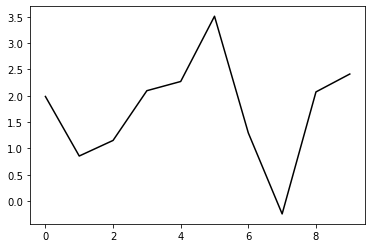

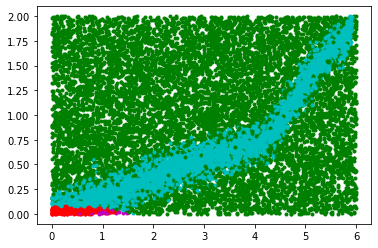

1000 0.421309664290052
0.8176871852667694 1.310200310232184 -0.05447941626707328 -0.04032807707660589
[ 1.11093186  1.57488197  1.58432717  1.47222908  1.4906031   1.46644349
  0.54051609 -1.23060206  0.30457595  6.78313778]


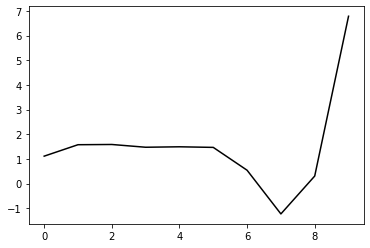

2000 0.42492133715843433
0.8324390927046446 1.2281911551165716 -0.06312888130053171 -0.05677536505783628
[ 1.0348512   1.24619017  1.41223604  1.51916271  1.52542797  1.32914565
  0.62411984 -0.90244005  0.19601755  8.10952194]


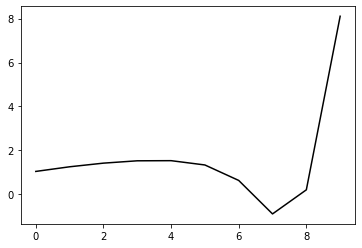

3000 0.3683946898107604
0.8291934059786268 1.1322864966375785 -0.05949816637770608 -0.05189580967021464
[ 0.97946054  1.04356907  1.12615128  1.1753915   1.1397268   0.91694101
  0.29578347 -0.97475096 -0.36615288  7.98238909]


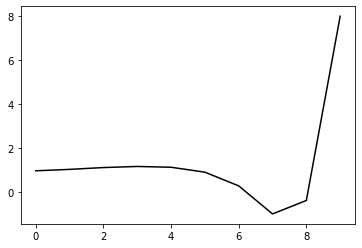

4000 0.4032529586922958
0.8289383648170227 1.0518892862405331 -0.05816123179316997 -0.06103214437117562
[ 0.93149035  0.99926504  1.0560641   1.07584228  1.01737664  0.79335831
  0.23293933 -0.86464105 -0.54486635  7.95643461]


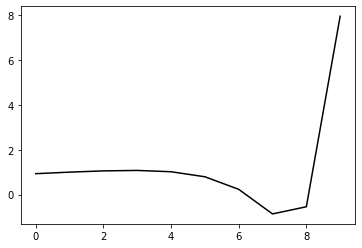

5000 0.47219090678324743
0.8281268224557563 0.9834601803059729 -0.0613196177595424 -0.06612003790740975
[ 0.8980933   0.95176681  0.99068628  0.99515381  0.92848532  0.70707382
  0.18525204 -0.79420918 -0.70419378  7.91589091]


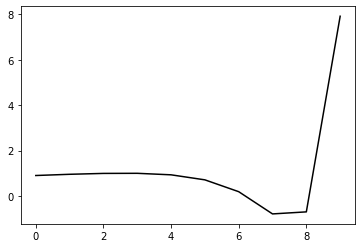

6000 0.5234960792104326
0.8337059883963049 0.8036221722945455 -0.05510620166425259 -0.07556483141407674
[ 0.90412413  0.89842743  0.98164073  0.99292889  0.91779225  0.69987939
  0.20901088 -0.70386459 -0.7509718   7.96593427]


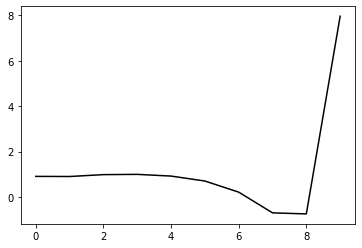

7000 0.38022378461349066
0.8260200439171338 0.6732519894324239 -0.0588449569647739 -0.06745146375948002
[ 8.16571788e-01  8.63573070e-01  8.72338684e-01  8.42962538e-01
  7.41702867e-01  5.01015167e-01 -1.48820720e-04 -8.91704259e-01
 -1.11669434e+00  7.87558635e+00]


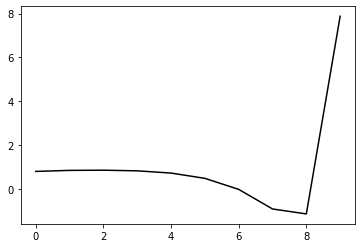

8000 0.3246889673032334
0.8300178960747608 0.5515494577994416 -0.05854745355819311 -0.07208824798085127
[ 0.7652541   0.85819218  0.86225943  0.83162442  0.73352972  0.50457871
  0.03225259 -0.80823019 -1.1195798   7.84145408]


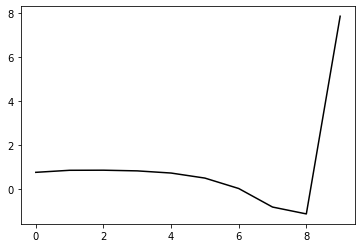

9000 0.41769942884369
0.8158583478703163 0.3574033087684626 -0.05670293417766246 -0.07210032950558866
[ 0.78335389  0.70439056  0.67455845  0.6025953   0.46625394  0.21197794
 -0.26157219 -1.07577386 -1.46461575  7.78013966]


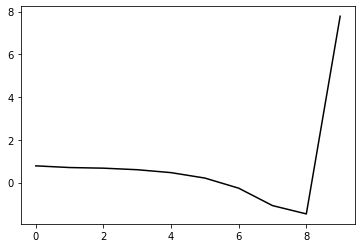

10000 0.3585803594630234
0.8106334252926721 0.06876976383668677 -0.06423843234844796 -0.07667760439117012
[ 0.79004754  0.71260001  0.67899334  0.58407506  0.41454306  0.1289327
 -0.36693218 -1.18988695 -1.63875498  7.76815031]


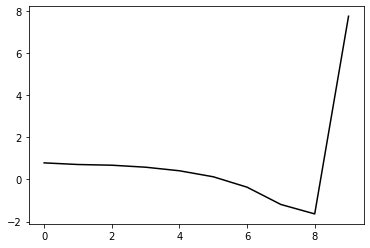

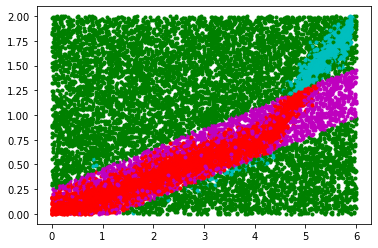

11000 0.36903165781273267
0.8006131033292786 -0.11460668071584 -0.06586505098261718 -0.07966702778835984
[ 0.79595576  0.72750137  0.67885471  0.59514997  0.43593059  0.14811411
 -0.3556387  -1.17486904 -1.67210962  7.73129374]


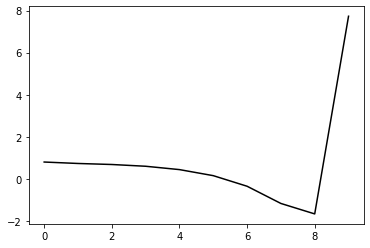

12000 0.3954987704633934
0.7876084117104885 -0.29665799961461214 -0.07779490820959006 -0.08880899545691553
[ 0.78509295  0.77883272  0.73764481  0.63997116  0.46917788  0.17601278
 -0.33193868 -1.15546822 -1.69415295  7.72895498]


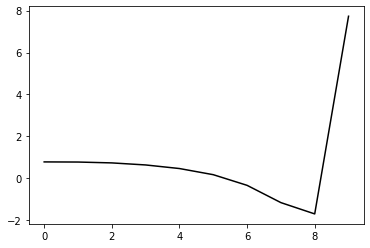

13000 0.16556337293430873
0.676220191289149 -0.745048031546837 -0.12013474158278746 -0.12134431899187458
[ 0.98619519  0.89480608  0.79874852  0.70269924  0.57649209  0.35232846
 -0.07453848 -0.80780302 -1.26830118  7.80824012]


14000 0.26190252897674665
0.6612779710125484 -0.7360625435649074 -0.12355595975031515 -0.1173967898130625
[ 1.03270036  1.01894675  0.95686936  0.85627145  0.70974999  0.48811841
  0.09647381 -0.60128988 -1.09045731  7.87111814]


15000 0.1673798451907573
0.6386609564073155 -0.7260782781181018 -0.12431346497871347 -0.11352235664577068
[ 1.07938601  1.09059554  1.05125155  0.97984161  0.85515086  0.6337301
  0.23607325 -0.45906624 -0.99690388  7.85547547]


16000 0.17054581217252435
0.6130134833433393 -0.7133136998981238 -0.12347512064581108 -0.10694988194842331
[ 1.15026765  1.10502133  1.05483554  0.98137042  0.86308536  0.64669358
  0.23913185 -0.4797728  -1.08966056  7.84394854]


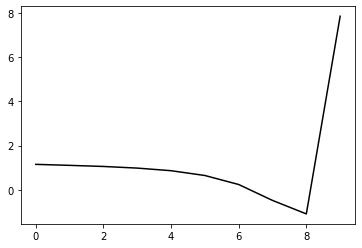

17000 0.27959227407607323
0.5928840929421392 -0.7069316840884748 -0.12450477880134583 -0.10571675102425214
[ 1.15299779  1.14009062  1.11996102  1.06678665  0.95253878  0.72946323
  0.31119094 -0.42355864 -1.07983247  7.82241586]


18000 0.16800489819918366
0.576099717808844 -0.6961178669243834 -0.12528006636384142 -0.10223517292662285
[ 1.12408963  1.23332468  1.22920122  1.19365504  1.1061146   0.90771434
  0.50160011 -0.23813784 -0.93950233  7.86996287]


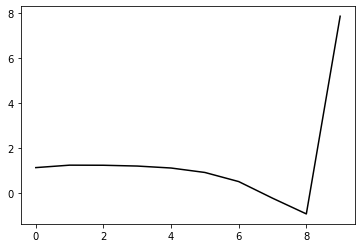

19000 0.2229041859291139
0.5627430100341823 -0.685768003309613 -0.12423546650616231 -0.09951990423573497
[ 1.13802421  1.27193836  1.28687907  1.2482454   1.1593321   0.96510908
  0.56360994 -0.18437161 -0.92853739  7.9066462 ]


20000 0.1574603243122526
0.5291003867843039 -0.6805381640263833 -0.1247170565678746 -0.10154901498125826
[ 1.1636777   1.15215513  1.16514478  1.14724849  1.07568907  0.90398885
  0.53487851 -0.18024862 -0.92207315  7.88045608]


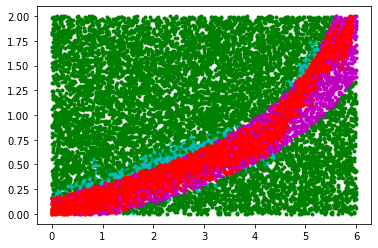

21000 0.22067813882753667
0.5219062547438656 -0.6714096950224163 -0.12462539910905097 -0.09927500111053798
[ 1.14978284  1.2275442   1.24467189  1.22593137  1.16450907  1.01056572
  0.66439912 -0.03095901 -0.78598547  7.89373933]


22000 0.18032197872518238
0.5040336677087203 -0.6605349796321228 -0.12381709941084398 -0.09809576442519309
[ 1.15515956  1.17589851  1.15796019  1.11459603  1.01709453  0.82662958
  0.46228048 -0.22726259 -0.98321038  7.87499457]


23000 0.17679280391520263
0.49603452034800743 -0.6543120557277265 -0.12476028448396899 -0.09845641150023632
[ 1.18701644  1.14627358  1.16261831  1.14869349  1.08379997  0.92201375
  0.57912084 -0.08508135 -0.82552851  7.8715048 ]


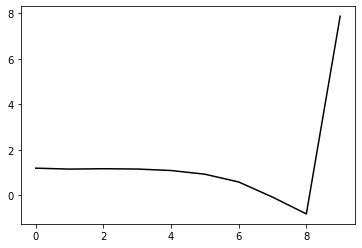

24000 0.20211195498863763
0.486917262797697 -0.6485549014765793 -0.12652905591535032 -0.09728015904326123
[ 1.15589773e+00  1.21476999e+00  1.23991444e+00  1.24234143e+00
  1.18791116e+00  1.02786805e+00  6.77925177e-01  3.50556851e-03
 -7.52960804e-01  7.90286594e+00]


25000 0.21143023931415772
0.4783152794395238 -0.6365301238231245 -0.12389328195775157 -0.09636131255447089
[ 1.15177453  1.20169783  1.23887451  1.24086407  1.18483792  1.02521537
  0.67100143 -0.01692619 -0.79598474  7.9125586 ]


26000 0.2722906580720656
0.4638039486982833 -0.6290745021530592 -0.12339281734671492 -0.09873571670062548
[ 1.16247232  1.14610759  1.16785865  1.15592139  1.09727853  0.9523472
  0.62598392 -0.03581429 -0.8018064   7.90880937]


27000 0.21746772564611105
0.4587066021467653 -0.6206094652645953 -0.12407761951965811 -0.09995128741825127
[ 1.1524886   1.13978231  1.16195756  1.17490968  1.14160966  1.0079344
  0.68851414  0.03632643 -0.72773179  7.91098778]


28000 0.15599807503731594
0.4446269482781683 -0.6153749306818231 -0.12583122121615678 -0.09759923065831885
[ 1.12588251  1.18997825  1.20762136  1.19062343  1.13345619  0.99526267
  0.68291773  0.0413011  -0.71717493  7.90773321]


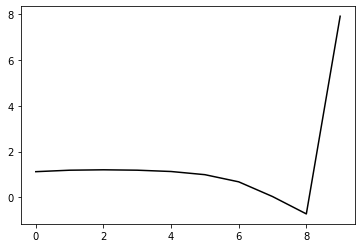

29000 0.1853648683903909
0.4323723142683411 -0.6095108311079706 -0.12671466301826342 -0.10171908168409181
[ 1.1220512   1.13266715  1.16220872  1.15859929  1.09587254  0.94376176
  0.6238559  -0.01351391 -0.76616976  7.88471791]


30000 0.27544930640810067
0.43220907280858195 -0.6006275742964089 -0.1263507379626647 -0.09954855391194312
[ 1.16398362  1.12356242  1.141874    1.14778879  1.10674571  0.97178236
  0.65805123  0.02842903 -0.7137878   7.93161541]


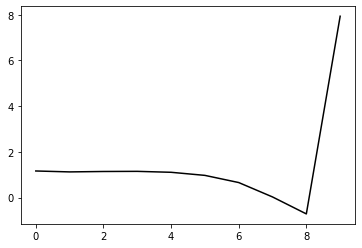

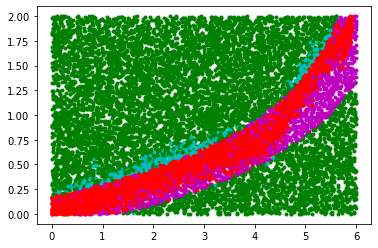

31000 0.2862824618442796
0.42777512368656095 -0.5940984256413147 -0.1278840296620563 -0.10328222092125156
[ 1.13882302  1.12510143  1.15601253  1.15760355  1.10750932  0.96221291
  0.64292958  0.01372874 -0.72009065  7.88758375]


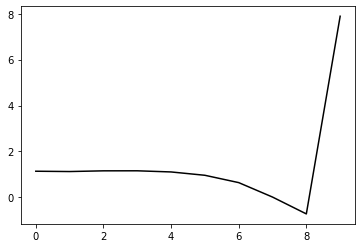

32000 0.33102869619865277
0.4265324985085287 -0.5847855888037418 -0.12636546110131047 -0.10196416573959145
[ 1.17928719  1.15248601  1.18356689  1.17488018  1.13162982  1.00052583
  0.68915003  0.06278897 -0.6669772   7.92028379]


33000 0.20315959116052715
0.41756863140224504 -0.5786008182439 -0.12807877531652867 -0.10022951634782346
[ 1.12691817  1.13455524  1.14221207  1.14434036  1.10754614  0.97141854
  0.65374656  0.01896331 -0.72217379  7.90925478]


34000 0.2591283052911792
0.41286577480814124 -0.5687784166293297 -0.12564486294635294 -0.10009074148286666
[ 1.12614734  1.12765551  1.14311982  1.13281104  1.08385599  0.95249565
  0.64754501  0.02659032 -0.69961505  7.91704424]


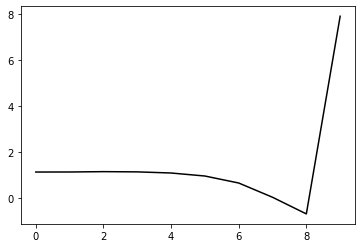

35000 0.14426284447561089
0.39852757543199396 -0.5694177945465505 -0.13118266200243908 -0.09938328919845753
[ 1.09040078  1.12362292  1.1272335   1.10528557  1.05162128  0.9265004
  0.63805488  0.03787635 -0.66869335  7.94006896]


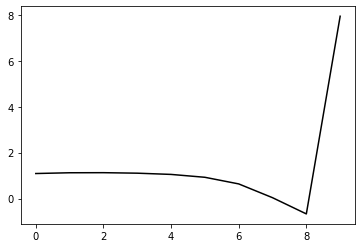

36000 0.2373246489248589
0.40163121986299827 -0.5574050280277691 -0.12859364730007736 -0.10381094130120372
[ 1.12712574  1.12850482  1.14580644  1.14354751  1.09404416  0.95625598
  0.65925623  0.06488481 -0.62850405  7.92734595]


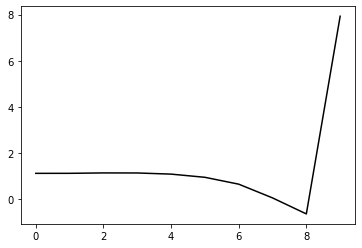

37000 0.2087188320770628
0.40184634906361 -0.5490068559401445 -0.12863984592552932 -0.09999204378750828
[ 1.07689566  1.16706082  1.18459131  1.17345289  1.121708    0.98631859
  0.68543387  0.08717026 -0.60603353  7.94452266]


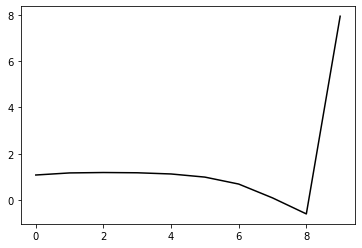

38000 0.27821616528934834
0.4029703572063909 -0.5446887600973044 -0.1321859031479921 -0.0936785493619015
[ 1.00925824  1.07718793  1.07082012  1.04082637  0.98716102  0.86674247
  0.59053872  0.01834625 -0.64760608  7.92908618]


39000 0.27333209556991384
0.3913870038268482 -0.5406422011214818 -0.13292992234669104 -0.10098961658895485
[ 1.05192502  1.0917118   1.0853889   1.04679807  0.98277601  0.86699831
  0.61090269  0.06684686 -0.57054838  7.95160743]


40000 0.20300686220716255
0.3858051635878992 -0.5350601712246338 -0.13278035229362958 -0.10384231869476451
[ 1.10897492  1.11840627  1.11323453  1.08824107  1.02134212  0.89006387
  0.62878403  0.10176074 -0.5070289   7.96246721]


41000 0.18436275851649508
0.3878151881318421 -0.5223721940372053 -0.12967071163119198 -0.10174701868782461
[ 1.10519852  1.08940059  1.08333411  1.05580786  0.99660846  0.86656197
  0.59646611  0.07141819 -0.52095791  7.9486695 ]


42000 0.1567080256033256
0.38215227880304325 -0.5217797330679123 -0.132965276933959 -0.10311073903826531
[ 1.08714474  1.13636139  1.17972109  1.17330616  1.10931605  0.96671069
  0.68027358  0.14518867 -0.43305882  7.97436116]


43000 0.19730508576188485
0.3738983489299912 -0.5183503589582781 -0.13550314591328602 -0.10177668472992288
[ 1.12555131  1.07633682  1.07681543  1.06588641  1.02332456  0.9078425
  0.64430559  0.12881918 -0.41417318  7.97799025]


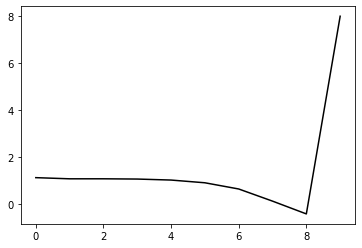

44000 0.265996195482178
0.3722963403546252 -0.5039807668123898 -0.13091230127721823 -0.1034288396990071
[ 1.11181341  1.11126394  1.11199286  1.06540301  0.98277146  0.83571916
  0.55177413  0.01951343 -0.52949679  7.96146744]


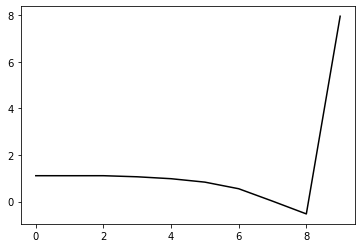

45000 0.2091471922684299
0.3669256219978756 -0.5010486404033205 -0.13248740399419506 -0.10580477774485379
[ 1.0870593   1.07571945  1.07637811  1.06013366  0.99563484  0.83839364
  0.53343551 -0.01272945 -0.5605245   7.95864915]


46000 0.21288673500844163
0.3526153643615745 -0.499694372594177 -0.1359059614421293 -0.10551429795287871
[ 1.10797227  1.07471808  1.08310567  1.07986981  1.03831936  0.92174803
  0.65163926  0.12387508 -0.40385326  7.97744199]


47000 0.2049372347305535
0.3543361786321135 -0.4903826276527425 -0.1355657624727081 -0.10365383559607519
[ 1.11026602  1.12577834  1.11690574  1.10112404  1.04279572  0.90477698
  0.62130419  0.08167714 -0.45446827  8.01599504]


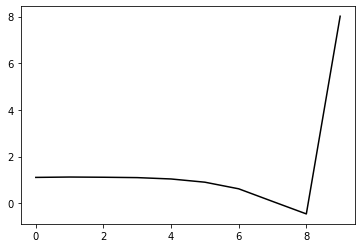

48000 0.14910870723517
0.3580098940103775 -0.4820642539214661 -0.13504181851780195 -0.10090087853958145
[ 1.09377386  1.17874111  1.18550405  1.16907455  1.11938453  0.98882593
  0.70098706  0.15375232 -0.38771202  7.96770588]


49000 0.18561588318559546
0.3523515650040527 -0.4802659253558861 -0.1375607527125216 -0.09944072507447219
[ 1.03817885  1.12157436  1.12717523  1.10073084  1.03471108  0.8977124
  0.61723775  0.07959778 -0.4475138   7.9716719 ]


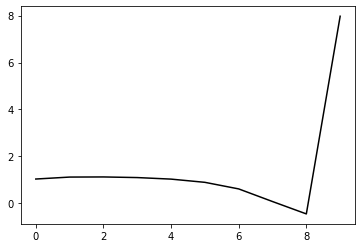

50000 0.3117373821692065
0.3544316921578993 -0.4677460491669855 -0.13478084360246306 -0.10264504701741341
[ 1.11263771  1.11902648  1.1596261   1.15656103  1.09960403  0.95089426
  0.64949097  0.09505611 -0.44749938  7.95840988]


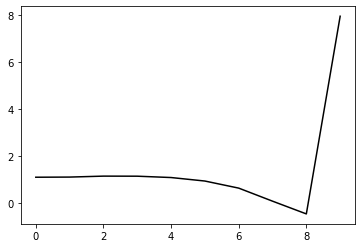

51000 0.16576204120404214
0.3443919971656875 -0.4695117534474773 -0.13839272717039447 -0.10373103982504411
[ 1.0976228   1.11508451  1.12488871  1.12146674  1.07353559  0.93932273
  0.64432122  0.09239248 -0.43769148  8.01008089]


52000 0.1793439002702498
0.3471733266321032 -0.46178006447891434 -0.13714390476710547 -0.10728064448214725
[ 1.09669814  1.17451764  1.20648124  1.18861152  1.12550225  0.98663159
  0.69539015  0.14615899 -0.37624503  7.98030799]


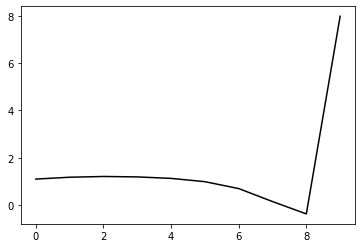

53000 0.23443015440720627
0.33750810997173974 -0.46071037557670236 -0.1398635539955414 -0.10422048365061755
[ 1.08411506  1.09636899  1.07711011  1.04090188  0.97956382  0.84710281
  0.55896734  0.01062062 -0.51053273  7.95963974]


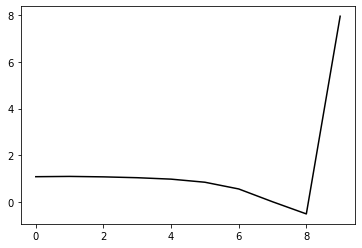

54000 0.2686724568500584
0.3412426436721408 -0.4530754103095924 -0.14105288401526714 -0.1057221710758813
[ 1.10959313  1.09775147  1.11164354  1.11207144  1.07024691  0.94365077
  0.66434091  0.12767187 -0.38272737  7.97869905]


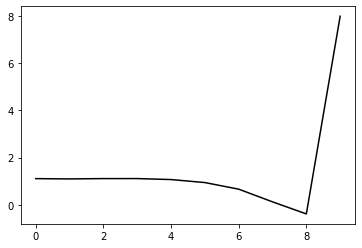

55000 0.2842050413212438
0.3370245412118107 -0.4422277228216782 -0.1366784341755796 -0.10703930655872355
[ 1.12001219  1.03869457  1.03623066  1.02727405  0.98299573  0.86173819
  0.58816921  0.0556736  -0.451573    7.96271783]


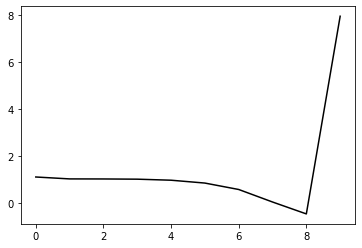

56000 0.18290483902220286
0.3421475826449443 -0.43487355592114696 -0.13868653629581904 -0.10366580115773952
[ 1.07527036  1.09978781  1.10984226  1.09332761  1.03944492  0.9118933
  0.63759712  0.10860546 -0.39517775  7.99765939]


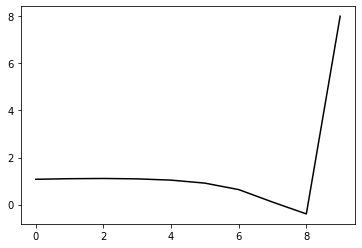

57000 0.27037815365335377
0.3385663878395307 -0.43234189147115587 -0.13972759484427674 -0.10549443384335501
[ 1.09347837  1.1138229   1.1204627   1.1003843   1.04068577  0.91379886
  0.6535287   0.14850862 -0.32775317  7.97033823]


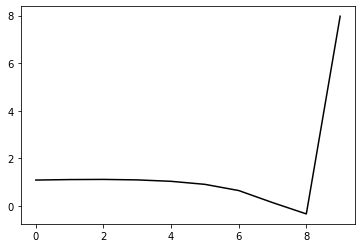

58000 0.24330809896676803
0.3283264912077426 -0.43248504503736984 -0.14142315349978934 -0.10834696576820678
[ 1.09425831  1.09073522  1.10604179  1.08404906  1.0194783   0.89021016
  0.63067654  0.13871045 -0.31471961  8.00471131]


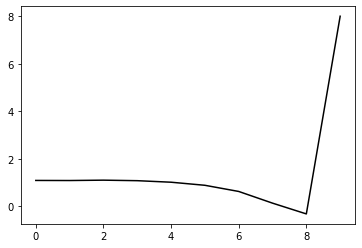

59000 0.24419290831723287
0.33107131517871236 -0.4258726177710198 -0.14095272589203497 -0.10891093116378622
[ 1.05289165  1.12428079  1.12555661  1.08252625  0.99963069  0.84673782
  0.56680135  0.06594717 -0.38421858  7.96874797]


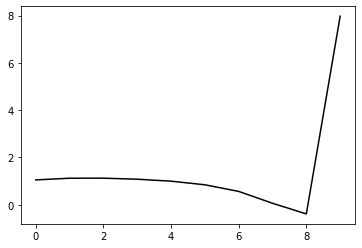

60000 0.1915027162630193
0.32646554965693775 -0.42439184737086877 -0.1439864721588727 -0.10825193620901113
[ 1.06493343  1.10467454  1.11612189  1.10637593  1.04835389  0.91038296
  0.63302414  0.1346037  -0.30170482  7.99418804]


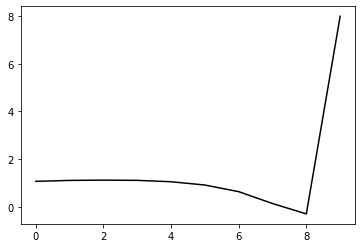

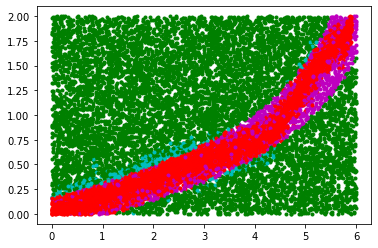

61000 0.22283876252272722
0.3285281624921889 -0.41612570958397194 -0.14380764740294152 -0.10733331049172488
[ 1.0649844   1.1580546   1.15217253  1.12564097  1.06253367  0.92192969
  0.64038757  0.13455237 -0.30038011  7.99637748]


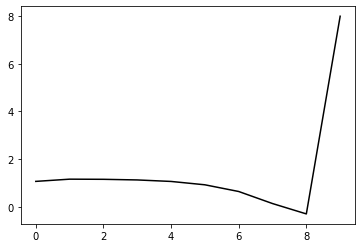

62000 0.17149530964761106
0.32340961720509653 -0.40864693676338887 -0.14255869508100044 -0.1042261851030134
[ 1.07374823  1.07745514  1.06184465  1.03420705  0.97315331  0.83650347
  0.55765847  0.04920776 -0.3867856   7.98510679]


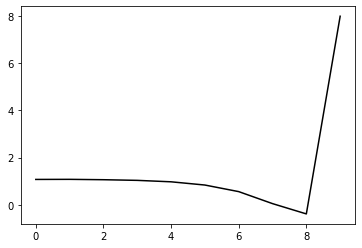

63000 0.16006780367425213
0.3231962209035335 -0.40855297144375574 -0.14630909587488666 -0.10389185813382029
[ 1.03942768e+00  1.04683236e+00  1.06064986e+00  1.03314484e+00
  9.54371754e-01  8.00330442e-01  5.11893776e-01 -1.68002715e-03
 -4.36667642e-01  7.97637201e+00]


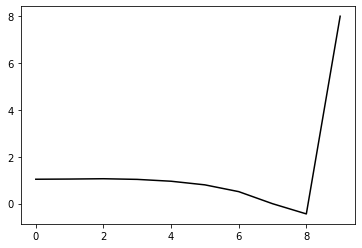

64000 0.20358985577430802
0.32011506117200217 -0.4024177570364141 -0.14511292655565905 -0.10510161914099898
[ 1.06794066  1.129675    1.13318075  1.12332707  1.07855125  0.94964892
  0.6681333   0.15513467 -0.27676784  7.99190521]


65000 0.18959935176233192
0.31417585770737344 -0.40071498138781203 -0.1461006091882077 -0.10907385588841612
[ 1.07309182  1.05907812  1.05595545  1.04118651  0.98680118  0.85534159
  0.58400228  0.08181351 -0.33455129  7.98768822]


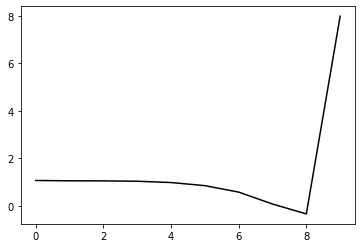

66000 0.23159147812585304
0.3103359093813708 -0.3955788849785855 -0.1463554377007223 -0.10821349664715658
[ 1.08219967  1.11561143  1.08558741  1.0587884   1.0089555   0.89235148
  0.63594626  0.14519378 -0.26575043  7.99755589]


67000 0.2520497749766889
0.3066674758155739 -0.3905858019651247 -0.1458390056165304 -0.10980516810504892
[ 1.08578882  1.05538562  1.05165902  1.02719371  0.95893715  0.82276677
  0.55897993  0.06888856 -0.34271421  7.9907173 ]


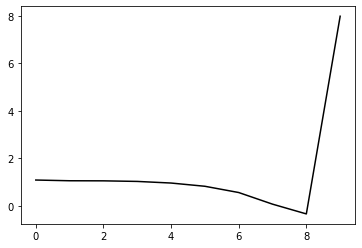

68000 0.26616307040948506
0.30581430462252235 -0.38969604122612767 -0.1491800219627472 -0.10749069202862176
[ 1.02149651  0.98520872  0.94848306  0.91787881  0.8734347   0.75855168
  0.50247613  0.02385052 -0.37104774  8.00369714]


69000 0.2906037250592241
0.3082018500642518 -0.379751254825951 -0.14705241062729393 -0.10699148970388629
[ 1.02574958  1.01974107  0.99292237  0.95442491  0.89240839  0.77326795
  0.52849817  0.06072396 -0.32591024  8.02379357]


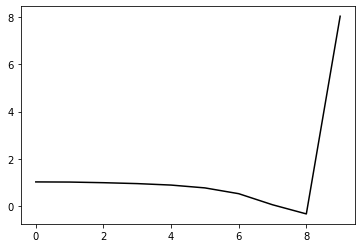

70000 0.24775846471823373
0.29867951544890564 -0.37859614056021607 -0.14926882668045496 -0.10873103222441727
[ 1.08243485  1.11048856  1.02475503  0.96299527  0.88183557  0.73909307
  0.48033751  0.01268899 -0.36870662  7.98261295]


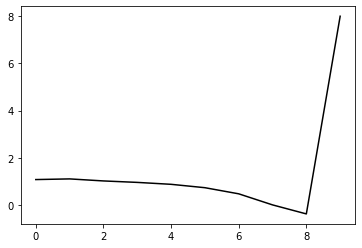

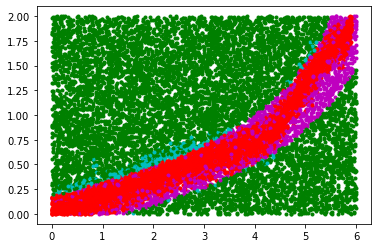

71000 0.1908124393113259
0.2996964661426697 -0.37538149689987926 -0.15078443447263126 -0.10904283996877986
[ 1.01857972  0.97716456  0.96104183  0.9238339   0.84363645  0.69498379
  0.42419288 -0.04659866 -0.42066224  7.98596116]


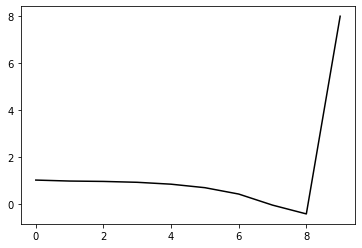

72000 0.22995822406381303
0.3065543491239486 -0.36289282945966833 -0.14692167700314937 -0.11094363200355892
[ 1.06273822e+00  1.06742754e+00  1.06139241e+00  1.02697769e+00
  9.51501230e-01  7.89905741e-01  4.91304567e-01 -6.69806929e-03
 -3.94917159e-01  7.98743923e+00]


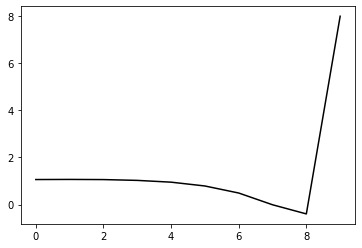

73000 0.24335404430382382
0.2988960872552103 -0.3667331186007773 -0.1511915479165424 -0.11543740628157412
[ 1.09391219  0.99124961  1.00381097  0.98037409  0.89467215  0.72576566
  0.42258121 -0.0801459  -0.45521416  7.96959615]


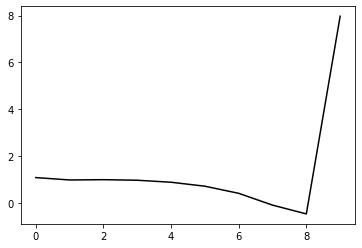

74000 0.23286564383080846
0.30133993615150506 -0.35862480547243764 -0.14901230898017603 -0.11366981568463082
[ 1.06778672  1.01609976  1.00281501  0.97569127  0.90813728  0.76518854
  0.47490482 -0.03233493 -0.41180407  8.01802929]


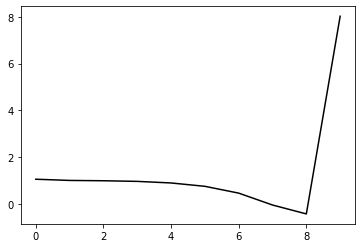

75000 0.2117794048197307
0.2956820538533452 -0.35812290806870245 -0.1503473865471484 -0.11607633872775462
[ 1.07911389e+00  1.02746133e+00  1.00766492e+00  9.73059374e-01
  9.08420597e-01  7.73903815e-01  5.00055601e-01  6.79515356e-03
 -3.57161877e-01  7.99327493e+00]


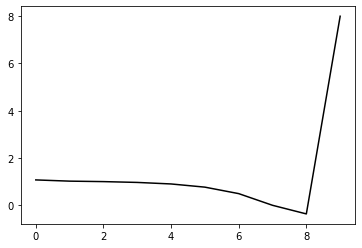

76000 0.19835101830219745
0.2953074247536424 -0.3588941346054314 -0.15419528386984155 -0.11584884495038807
[ 1.06993274  0.94473776  0.94111408  0.92478045  0.86419274  0.7288168
  0.46184488 -0.01966688 -0.37288606  7.99476365]


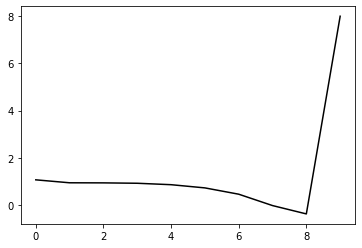

77000 0.23722749905565188
0.30194530113605433 -0.3449286350070385 -0.15042385797445545 -0.11297602335758777
[ 1.0811623   1.04685968  1.03862202  1.01053113  0.94176196  0.79984882
  0.52333649  0.03157598 -0.33665904  8.00212385]


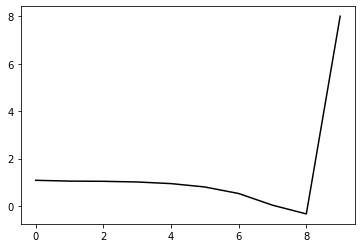

78000 0.20979240872935365
0.30369205077732075 -0.3457542550390403 -0.15486766055198822 -0.10968828047053532
[ 1.03882714  1.09489423  1.07090549  1.01833818  0.93205849  0.7823875
  0.50666611  0.01769644 -0.34668404  7.99042661]


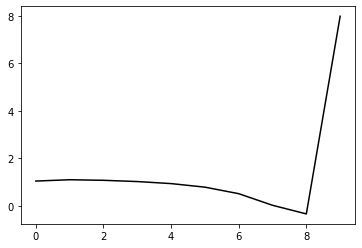

79000 0.15037858762548173
0.29899620959842094 -0.3464333213126215 -0.15669397408274136 -0.1139865813672354
[ 1.08181179  1.02435657  1.01782512  0.9701868   0.88263033  0.72721346
  0.44708007 -0.03271865 -0.37603977  7.99322711]


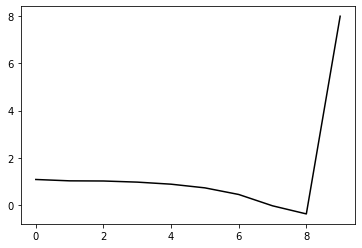

80000 0.23383223366058115
0.29877428766295805 -0.3384541868122649 -0.15450702956814136 -0.11146697010133069
[ 1.0619668   1.05043342  1.03174805  0.99067765  0.91924185  0.77173018
  0.49101807  0.00893392 -0.33427314  7.97964746]


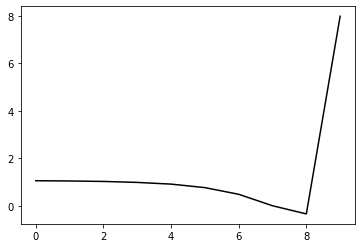

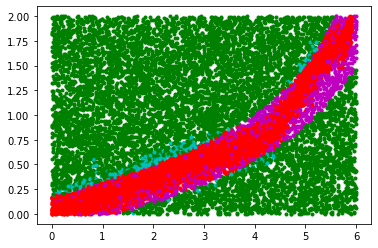

81000 0.19489286178817836
0.29077806441570225 -0.3333812218966772 -0.15488200251781356 -0.1086235760604968
[ 1.08128615  1.07360132  1.04043692  1.00954107  0.94579346  0.80571549
  0.52867499  0.04175859 -0.31049795  7.96420029]


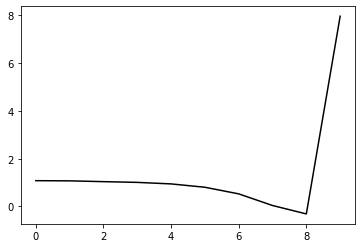

82000 0.1909494877208329
0.29088608633373886 -0.3307831502692922 -0.15546966786280608 -0.10948428280464552
[ 1.05996098  1.09913499  1.08137365  1.04425633  0.98182739  0.85084748
  0.58292461  0.10172011 -0.24708279  7.98584219]


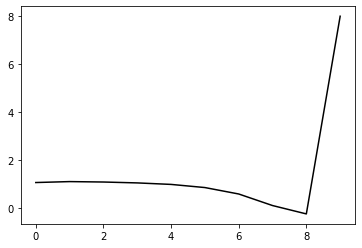

83000 0.22610323946720282
0.2837471780603606 -0.32879584228489545 -0.15500228673904415 -0.11282504073167143
[ 1.10269662  1.03632491  1.02661428  0.99599123  0.92270369  0.77986835
  0.51116649  0.03791068 -0.29811308  7.96847723]


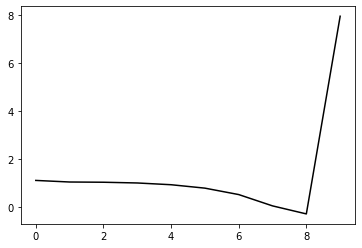

84000 0.3416440349920854
0.28970892598485404 -0.32448369797801807 -0.15712058372534754 -0.10614125983659574
[ 0.9730089   0.97280654  0.95045832  0.89466899  0.80695753  0.65871359
  0.38657623 -0.08891961 -0.42725398  7.97103674]


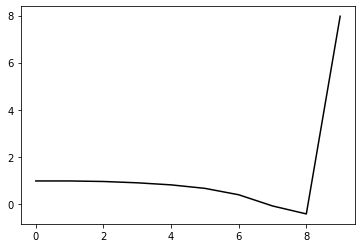

85000 0.2542134421557422
0.2844141760111199 -0.32487485007331796 -0.15784737509521748 -0.11528896389276497
[ 1.02670293  1.01175541  0.98497212  0.9272153   0.83460598  0.67630713
  0.40443301 -0.05745097 -0.37234797  7.98573229]


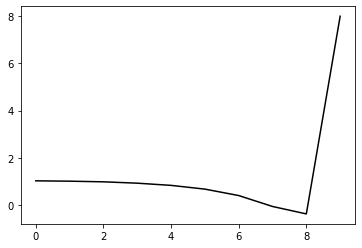

86000 0.18922871780058775
0.2814173633226555 -0.3176992268428263 -0.15522598888382322 -0.11569225378425357
[ 1.08099299  0.98443073  0.96847118  0.93226556  0.855297    0.70523747
  0.42615934 -0.04447591 -0.36337336  7.97791936]


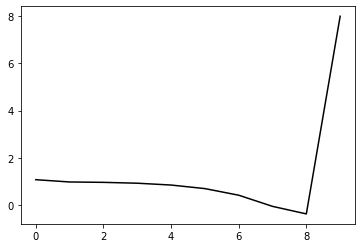

87000 0.3401644524831359
0.27522651522462155 -0.3171533811441713 -0.1563045818752858 -0.11695701189742488
[ 1.08617634  1.02059899  1.00636888  0.97927407  0.91840237  0.78978321
  0.53027029  0.06948961 -0.24194966  8.04073687]


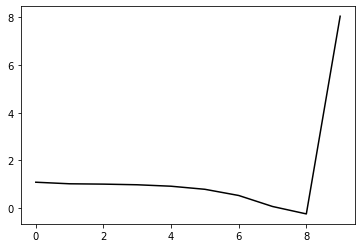

88000 0.1863087738284296
0.2779437687167597 -0.3149793258251701 -0.15910810929356495 -0.11377465361033942
[ 1.03399686  1.08068771  1.0771649   1.03490905  0.95348742  0.81039715
  0.54277964  0.07563498 -0.24112273  8.00126302]


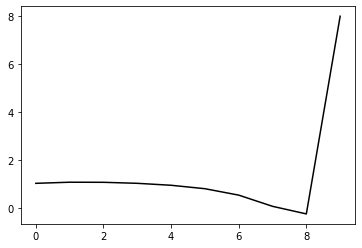

89000 0.2084621651880673
0.2736932650157322 -0.3103702928710077 -0.15739966014270143 -0.11318618965351684
[ 1.0189156   0.99618773  0.95523283  0.899623    0.83240513  0.70871005
  0.46427952  0.02376331 -0.26717686  7.99664823]


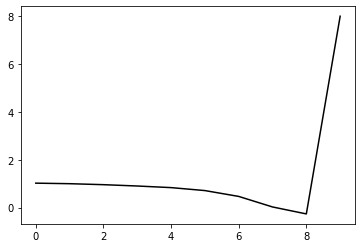

90000 0.2940049066595448
0.26982241148308383 -0.30796416738304006 -0.15731340520233014 -0.1169764557127046
[ 1.04807118  1.04050619  0.95363799  0.89040597  0.80535616  0.66163289
  0.40909141 -0.0321517  -0.32600559  7.99310146]


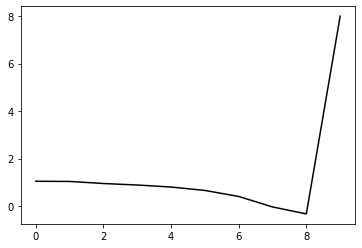

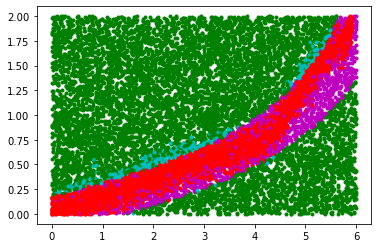

91000 0.16321499085678207
0.2698588253914371 -0.3111224396114761 -0.16194923086227783 -0.1188711032534215
[ 1.03856685  1.05150517  1.01015115  0.95507969  0.88682914  0.75889776
  0.51680229  0.09583789 -0.17006861  8.01580637]


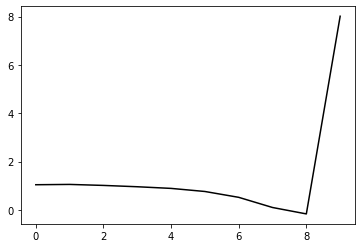

92000 0.21406719603403185
0.27003209988183197 -0.300500975513541 -0.15880567357336825 -0.1147109097723882
[ 1.02594239  1.0424075   1.03952334  0.99652218  0.90436816  0.7501721
  0.48811889  0.04953697 -0.23223534  7.98900299]


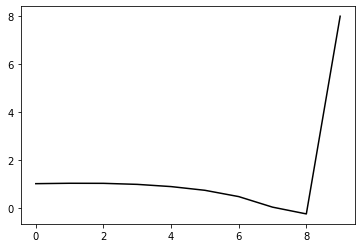

93000 0.16328592515630366
0.2656985886104902 -0.30150651916541865 -0.16142030234652 -0.11530617504687106
[ 1.05025476  1.07048372  1.04704614  0.99586508  0.91301921  0.76716217
  0.50015582  0.05532043 -0.22439375  8.0190358 ]


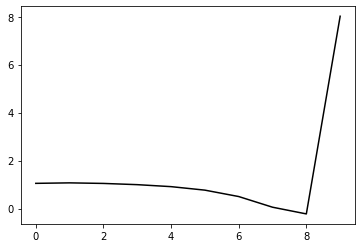

94000 0.1666935713116162
0.26357784142901175 -0.30067747532781497 -0.16375979805932317 -0.11497400709435839
[ 1.02756933  0.9817006   0.97153882  0.94278833  0.86354659  0.70916506
  0.43249868 -0.02378701 -0.30945033  8.01442124]


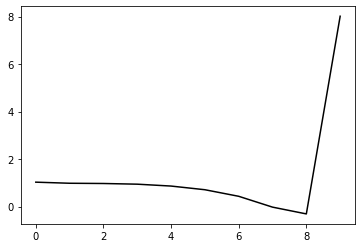

95000 0.14411551739426448
0.2654591202457957 -0.29391470211434845 -0.16214439733837535 -0.11400584217151452
[ 1.05316329  1.07874003  1.08103532  1.05572793  0.97779176  0.8211908
  0.53413811  0.05947349 -0.24296659  7.99628656]


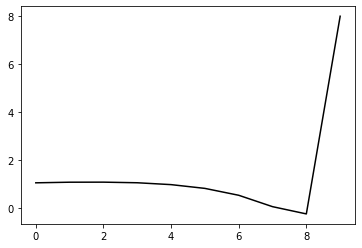

96000 0.2532270148112436
0.26992679138750664 -0.2879280539269266 -0.16239308991745732 -0.11090185811328163
[ 1.00769562  1.11856339  1.1316316   1.0892289   1.00334235  0.84306023
  0.54547237  0.05081511 -0.27033788  7.97953833]


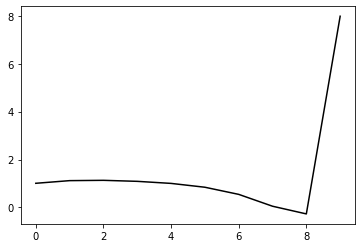

97000 0.16504166019986483
0.273069357380853 -0.2868268940927002 -0.16317274498791098 -0.1123814568328763
[ 0.96290708  0.99241069  0.99336227  0.94678514  0.8536501   0.67775112
  0.36335827 -0.1488175  -0.4819264   7.98531475]


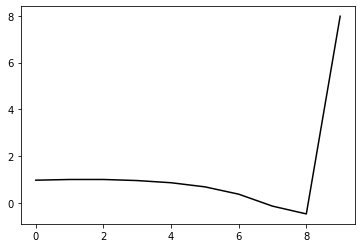

98000 0.3100875281742541
0.26940553814218837 -0.29237734850226066 -0.16861026634978912 -0.11309560906264216
[ 0.97125235  0.96472277  0.96627516  0.93966943  0.85508921  0.69207296
  0.3924477  -0.11023114 -0.43293004  8.01467813]


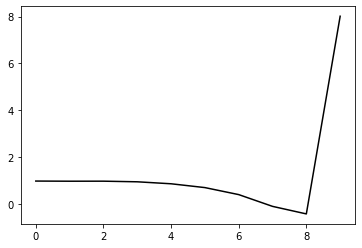

99000 0.20552949274938817
0.26885668030640747 -0.28429026371114313 -0.16484667436197917 -0.11626206691727606
[ 1.02439984  1.07343065  1.0592915   1.02379411  0.95242528  0.80522253
  0.51544684  0.01408521 -0.31474289  7.98646139]


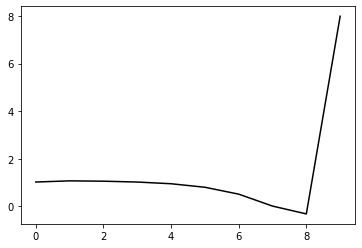

In [18]:
optimizer=tf.optimizers.Adam(learning_rate=0.0005)
for j in range (10000):    
    with tf.GradientTape() as g:
        loss=Error_func(h, m2, lam, alpha, beta, Positive[j%set], Negative[j%set])
        gradients=g.gradient(loss, [h, m2, lam, alpha, beta])
        if np.isnan(loss)==True: break
    for i in range (90):
        optimizer.apply_gradients(zip(gradients, [h]))
        if any(np.isnan(h.numpy()))==True: break
    for i in range (10):
        optimizer.apply_gradients(zip(gradients, [h, m2, lam, alpha, beta]))
        if any(np.isnan(h.numpy()))==True: break
    if j%100==0: 
        print(j*10, Error_func(h, m2, lam, alpha, beta, Positive[np.int32((j/set)%set)], Negative[np.int32((j/set)%set)]).numpy())
        print(m2.numpy(), lam.numpy(), alpha.numpy(), beta.numpy()), print(h.numpy())
        plt.plot(h.numpy(), 'k-'), plt.show()
    if j%1000==0:
        for i in range (set):
            [Positive0[i], Positive1[i]]=NN_func_01(h, m2, lam, alpha, beta, Positive[i])
            [Negative0[i], Negative1[i]]=NN_func_01(h, m2, lam, alpha, beta, Negative[i])
        for i in range (set):
            x_data1[i]=[v[0] for v in Positive0[i]]
            y_data1[i]=[v[1] for v in Positive0[i]]
            x_data2[i]=[v[0] for v in Positive1[i]]
            y_data2[i]=[v[1] for v in Positive1[i]]
            x_data3[i]=[v[0] for v in Negative0[i]]
            y_data3[i]=[v[1] for v in Negative0[i]]
            x_data4[i]=[v[0] for v in Negative1[i]]
            y_data4[i]=[v[1] for v in Negative1[i]]
            plt.plot(x_data4[i], y_data4[i], 'g.')
            plt.plot(x_data2[i], y_data2[i], 'c.')
            plt.plot(x_data1[i], y_data1[i], 'r.')
            plt.plot(x_data3[i], y_data3[i], 'm.')
        plt.show()

0 0.48134381614903876
0.2586221620280323 -0.27536192849515456 -0.1578857036930864 -0.12519955562144564
[ 1.09724918  0.99248432  1.06989891  1.03305748  0.95717029  0.80655849
  0.51520751 -0.08418534 -0.41819968  7.96206686]


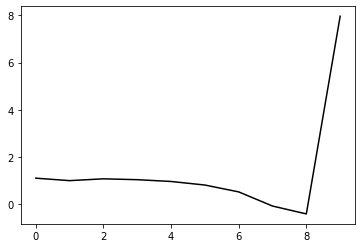

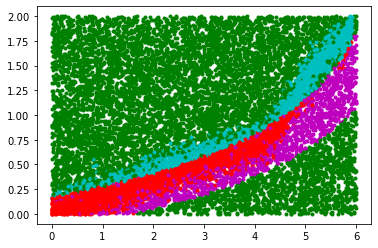

1000 0.18297869420553253
0.28377045237246656 -0.275832049709103 -0.16836664604845236 -0.12024172883988272
[ 1.00648421  1.01407333  0.98815102  0.91556484  0.79848817  0.61799095
  0.30491948 -0.27158064 -0.62181444  7.93523647]


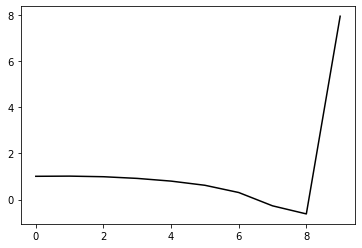

2000 0.22236048048278995
0.28001387166786706 -0.2722396398657976 -0.16778002523615218 -0.12248453863398553
[ 1.03892294  1.02584038  1.01283069  0.97335976  0.87630909  0.68954351
  0.35563122 -0.21654447 -0.59011004  7.98323579]


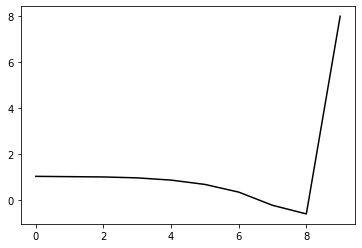

3000 0.19972265222501462
0.277278843461551 -0.26989192164979514 -0.16848213937563847 -0.12543853809936997
[ 1.00488096  1.0398837   1.03630813  0.99495409  0.89681292  0.71121253
  0.37359227 -0.19761209 -0.58436819  7.94595358]


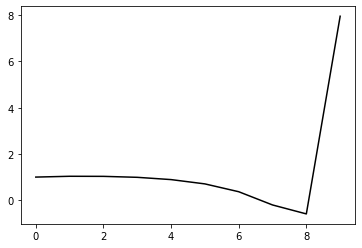

4000 0.2417167540948852
0.27595189956742244 -0.26840031691743876 -0.16885231531386796 -0.12710358838139563
[ 1.04748764  1.0069176   1.00452521  0.94624975  0.83353417  0.62640452
  0.26317575 -0.331275   -0.74702221  7.90749108]


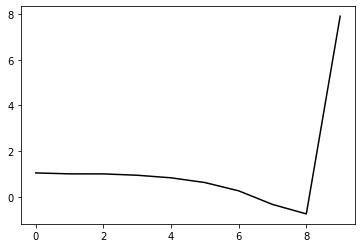

5000 0.24989201832972777
0.2769320790853539 -0.2678061215783722 -0.17070331119799861 -0.12676952801390268
[ 1.02334074  1.0370533   1.02745376  0.98269116  0.885169    0.7019895
  0.35784919 -0.22647816 -0.64237334  7.92808065]


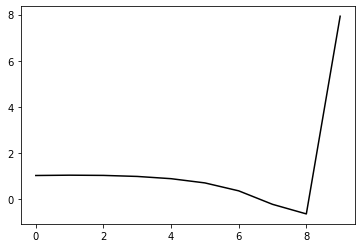

6000 0.15446887896843933
0.27760562645230663 -0.2649422502357156 -0.17136262944864722 -0.12702938192033716
[ 1.01568327  1.05355602  1.04043271  0.99984657  0.9033256   0.7138027
  0.36728527 -0.22045366 -0.65209492  7.92160973]


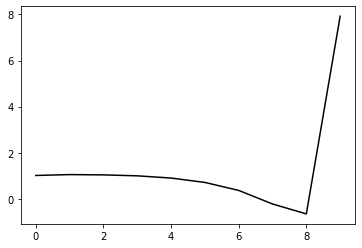

7000 0.20516851618508045
0.2731643076057957 -0.26173304102881595 -0.17238433029640157 -0.12429454127941682
[ 1.01899494  1.03044084  0.99895246  0.95912868  0.89114822  0.74563086
  0.43972833 -0.11984263 -0.54414362  7.94547959]


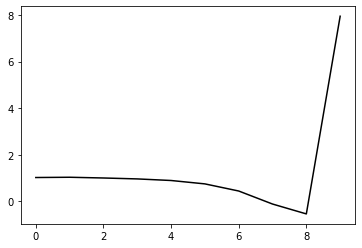

8000 0.24171735327875016
0.27090801816229876 -0.2573525887249778 -0.17137909938936668 -0.1251382292446357
[ 1.0328515   1.03437675  0.99184518  0.92748296  0.83484651  0.6769999
  0.3809388  -0.15876584 -0.57709894  7.93696283]


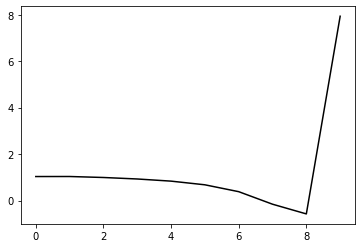

9000 0.24889576766264043
0.2744845340535887 -0.25398432905458895 -0.1735184491940226 -0.11864107722364922
[ 0.949955    0.99019005  0.98141402  0.90812981  0.78994976  0.60883487
  0.29984543 -0.2381935  -0.66344779  7.96965379]


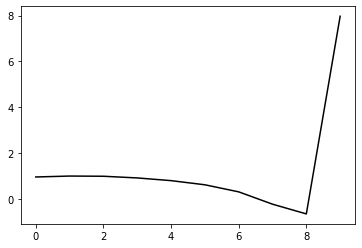

10000 0.17079950644887099
0.27040182271050844 -0.2553770580388243 -0.17385817388715014 -0.12437890205179863
[ 1.01478839  1.06954141  1.07088428  1.0050973   0.88921625  0.70565745
  0.39275803 -0.13699417 -0.54947403  7.95551902]


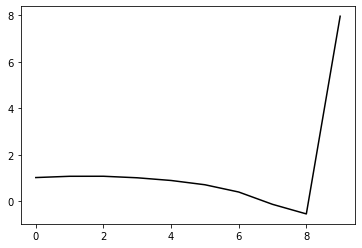

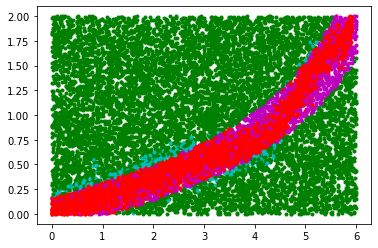

11000 0.2377600674560781
0.26443642520231764 -0.2559490584163404 -0.17609651622589959 -0.12042069316868823
[ 0.99795244  0.92612703  0.90333607  0.8641938   0.78786219  0.62897195
  0.32417692 -0.1988832  -0.60164644  7.95180245]


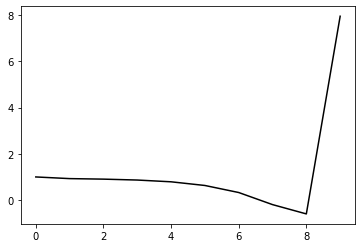

12000 0.3593352210564701
0.2595614300864236 -0.25065506630206835 -0.17344502905010437 -0.1236874964656222
[ 1.10791302  1.00745347  1.01580592  0.98494122  0.90680821  0.75281325
  0.45704823 -0.06619874 -0.47568768  7.95471424]


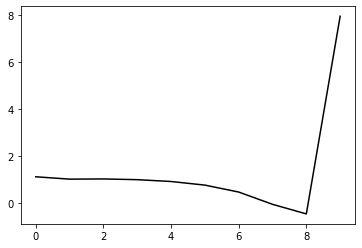

13000 0.16397672711316125
0.26135718629584404 -0.2501723464244657 -0.17639835938457316 -0.12328321057934327
[ 1.04888222  1.10931185  1.08044838  1.0301483   0.93757057  0.76298972
  0.45279374 -0.07852645 -0.49451802  7.9591025 ]


14000 0.24684066727897958
0.2620866370462622 -0.2500494858856977 -0.17614542999549823 -0.1278556719994093
[ 1.05655241  1.0164518   1.0098475   0.95869788  0.8482247   0.65541294
  0.32805154 -0.20907115 -0.61600597  7.9234392 ]


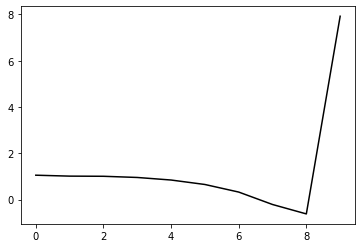

15000 0.18171259797116515
0.2580395142409248 -0.2483784704841163 -0.17634271490636028 -0.1259443154058956
[ 1.06367851  1.01663809  0.93396964  0.85910298  0.74940233  0.55856835
  0.22483866 -0.32083805 -0.72832962  7.91852357]


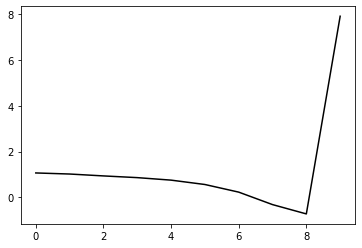

16000 0.11745216480997563
0.26406121763769375 -0.24732959550373554 -0.17876568601306006 -0.12667892589387977
[ 1.02198437  1.07626674  1.03869436  0.98705359  0.89905512  0.72643178
  0.40476091 -0.13536316 -0.53461826  7.95299217]


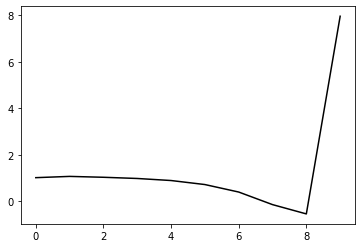

17000 0.2967857460229821
0.26594200625318815 -0.23971001592364422 -0.17638026447717017 -0.12226656082061936
[ 1.0843615   1.02382029  1.00820859  0.95419112  0.86153249  0.6869004
  0.36037863 -0.19702769 -0.62167667  7.93011606]


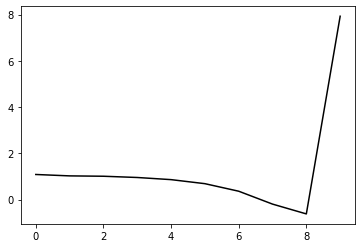

18000 0.176838648569474
0.26492144583630195 -0.23901950589001955 -0.178038872309213 -0.12181796048179738
[ 1.04604215  1.07042045  1.05460282  1.01865572  0.93589097  0.76027973
  0.42911704 -0.1335414  -0.56284466  7.94377182]


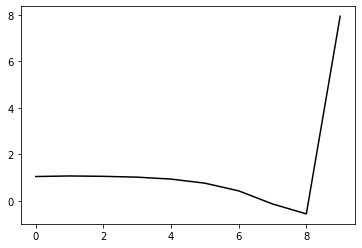

19000 0.2175766016035827
0.2666456777825309 -0.23845773975738455 -0.17908318123803713 -0.12126057655161859
[ 1.03025465  1.14680823  1.1236264   1.04649044  0.93558704  0.76063179
  0.44298863 -0.10900872 -0.53019637  7.94006249]


20000 0.17155513602337757
0.2643357750646366 -0.24028798301086252 -0.18066571703737522 -0.12399417697778986
[ 1.0932486   1.0148463   1.01191988  0.97350325  0.8763825   0.68780116
  0.3585564  -0.1895485  -0.59974575  7.93126604]


21000 0.2558491043893698
0.2622854611546805 -0.23786117775225982 -0.1789914734419527 -0.1286643638639694
[ 1.07326417  1.01997744  1.01079697  0.96716265  0.86144698  0.66191616
  0.31184873 -0.25720493 -0.68264805  7.92868114]


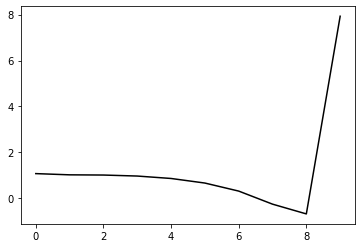

22000 0.17264417989444833
0.2601609845571785 -0.23453221372469382 -0.17915718653678162 -0.1253715905190746
[ 1.05469154  1.0209767   1.0180348   0.98261284  0.89263774  0.70687871
  0.35760347 -0.22450891 -0.66528254  7.88752368]


23000 0.15808078120513794
0.25730812654716473 -0.23653792632157086 -0.18118164554851107 -0.12575915437129262
[ 1.02546648  0.98852794  0.96489688  0.91113191  0.8175259   0.63968597
  0.30018901 -0.2837425  -0.73159549  7.92540367]


24000 0.24808373811789855
0.254753367419629 -0.235385964359008 -0.18131421622286167 -0.1284204776925239
[ 1.06574918  1.02464415  0.97477218  0.91466952  0.82163555  0.64310876
  0.30940097 -0.26909677 -0.71771321  7.92183906]


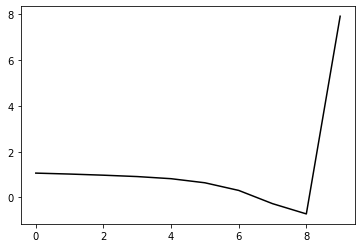

25000 0.22373195944986896
0.24671834384459435 -0.23229398925310155 -0.17895040809732707 -0.1284895317136772
[ 1.06116804  0.9950556   0.90035421  0.8188065   0.71691693  0.53765062
  0.20235828 -0.37810747 -0.83640667  7.90098431]


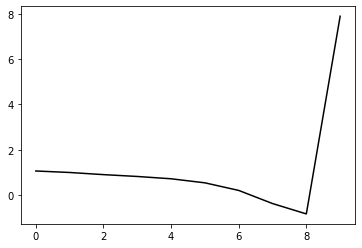

26000 0.23474562807039814
0.25440277200658945 -0.23041164672416498 -0.1791144039913796 -0.12897580689981664
[ 1.03123218  1.02742322  1.00852068  0.96094742  0.85879512  0.67075815
  0.33262708 -0.24415858 -0.698031    7.91474535]


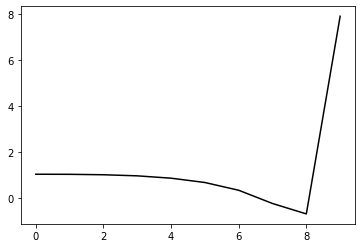

27000 0.1928042555952938
0.2527491009666724 -0.2292987213889989 -0.1806414744613741 -0.12521240054996574
[ 1.05441925  1.02994008  1.01431513  0.96767286  0.87763656  0.70436442
  0.37605518 -0.1967682  -0.65522358  7.94563958]


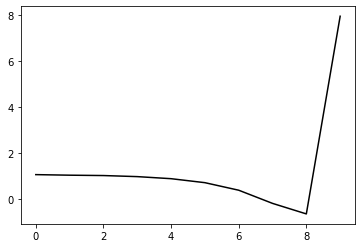

28000 0.1606738513570129
0.24925587515790973 -0.22936185895492361 -0.1818228986875583 -0.12553471874319752
[ 1.03382923  0.98585579  0.97140641  0.95007975  0.8819261   0.72657834
  0.41508307 -0.14524284 -0.60065914  7.93634677]


29000 0.1790387131989434
0.2513929679703319 -0.22363607774291847 -0.17965590140149934 -0.12508867213974886
[ 1.04149611  1.04530336  1.0281419   0.97751271  0.88254518  0.71674829
  0.40610525 -0.15270048 -0.6140865   7.9499702 ]


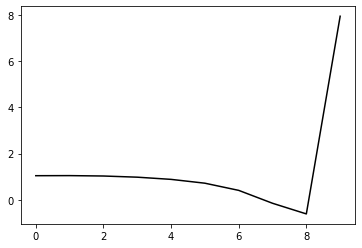

30000 0.26066711713766116
0.2475560676039221 -0.2247445530483783 -0.18205432509496994 -0.12218178012310713
[ 1.08325482  1.03955072  0.99954297  0.94047688  0.84837707  0.69312955
  0.39969608 -0.1341059  -0.57608722  7.99049409]


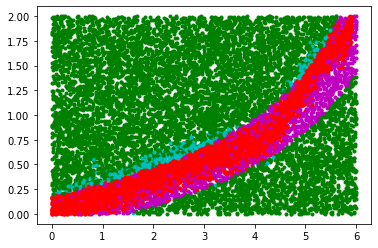

31000 0.245503194979955
0.2495198330061559 -0.22206493627618704 -0.18226458368550605 -0.12235090610367685
[ 1.03133433  1.0564262   1.03771807  0.98954631  0.89722493  0.72670979
  0.41992851 -0.11053208 -0.54217197  7.94501732]


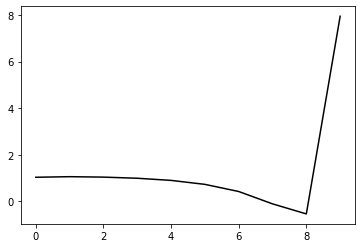

32000 0.18545955336493194
0.2494358057427582 -0.22239392183226972 -0.18381332527564298 -0.12308782973254144
[ 1.02607098  1.08186117  1.0569153   1.01460382  0.92231324  0.74805338
  0.43298281 -0.10234255 -0.53079971  7.96191055]


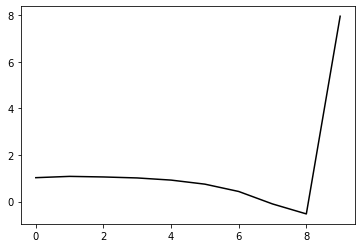

33000 0.23682015595338485
0.2408823528324542 -0.22001301204994256 -0.18069692461770548 -0.1241065185921214
[ 1.08269651  0.98291503  0.87689944  0.79748232  0.69453349  0.51756133
  0.2037762  -0.32758263 -0.74009463  7.91978398]


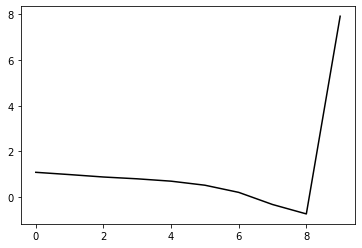

34000 0.2671676915819998
0.24717836945860938 -0.2211475468381609 -0.1834962012064336 -0.12554968577890838
[ 1.07382902  1.05968716  1.03336437  0.97078317  0.86040599  0.67900501
  0.36626236 -0.15547453 -0.54640795  7.95144199]


35000 0.16364437572387458
0.2503426146330541 -0.22438326213714513 -0.18782699406803838 -0.1205191972959356
[ 1.00813156  0.97881416  0.938389    0.85564033  0.73799731  0.55209105
  0.2306387  -0.29718423 -0.68380847  7.9301973 ]


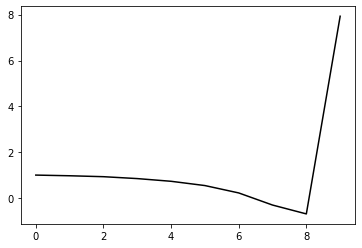

36000 0.28394497647296063
0.24919334448198388 -0.21973814216961232 -0.1853412978185072 -0.12601294972613727
[ 1.10463746  1.05270638  1.05869961  1.01654129  0.92013659  0.73783641
  0.41200573 -0.12266391 -0.51189567  7.9580741 ]


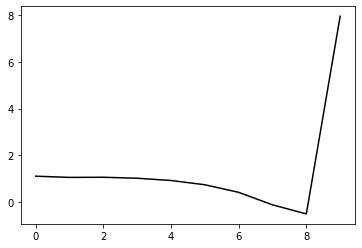

37000 0.3250829848235826
0.2534735423519581 -0.2220416127113871 -0.1885623100660782 -0.12446116361751773
[ 0.93554615  0.95049696  0.94936057  0.89058794  0.78131985  0.59223842
  0.25481649 -0.29609045 -0.69163905  7.95984551]


38000 0.16074260304665863
0.24895247720429597 -0.22027247795901408 -0.18581499219603384 -0.1296388478920816
[ 1.01819122  1.03170047  0.97587765  0.9110034   0.8111072   0.63732175
  0.31956287 -0.21661886 -0.59483157  7.95606208]


39000 0.23239520471040215
0.24263187165382555 -0.21935330086367438 -0.18618337630249707 -0.13031463118943584
[ 1.05970332  0.95932242  0.89646708  0.82482277  0.72563113  0.55778488
  0.25202571 -0.27188132 -0.64057345  7.9377    ]


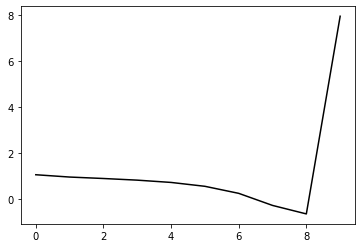

40000 0.18484620154977596
0.2502624150917145 -0.2141679074335508 -0.18442840226116905 -0.13107207936172646
[ 0.98808207  1.03816132  1.01284052  0.9506541   0.83848254  0.64826352
  0.32640818 -0.20643574 -0.58553852  7.92944065]


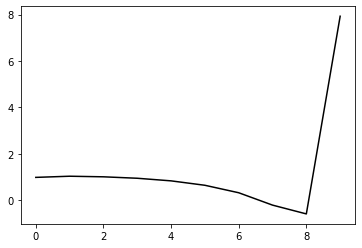

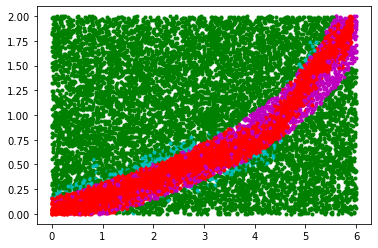

41000 0.23206977426879696
0.24459470523651683 -0.21503313038067892 -0.1850541773953195 -0.13195602312455154
[ 1.06218051  0.95116927  0.93614542  0.88502094  0.78161752  0.59819356
  0.27626775 -0.25273359 -0.62127136  7.94290236]


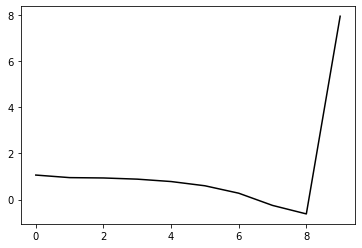

42000 0.16209433104582813
0.24759537162912607 -0.2111065826682206 -0.18457019281670783 -0.13002204761682046
[ 1.00331261  1.08470141  1.04739584  0.96793109  0.8472004   0.64629065
  0.30353951 -0.24809625 -0.63432187  7.92138214]


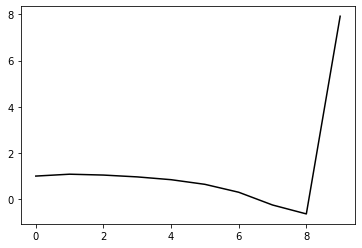

43000 0.19215450567983594
0.24999226041754358 -0.20861446345700865 -0.18398158893512703 -0.13060395301706262
[ 1.02818205  1.01574894  0.93650306  0.8630681   0.74417504  0.53404946
  0.17728592 -0.38861734 -0.78167356  7.91092766]


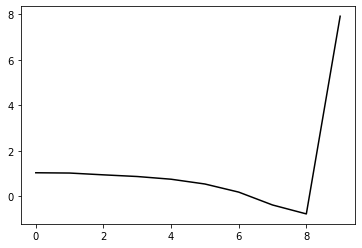

44000 0.237423498524716
0.2487468081856247 -0.21115710607251742 -0.18770177637783203 -0.1304397880567725
[ 1.05048841  0.97789616  0.93891113  0.86883944  0.76513373  0.5807822
  0.24517617 -0.30906735 -0.69054014  7.90301745]


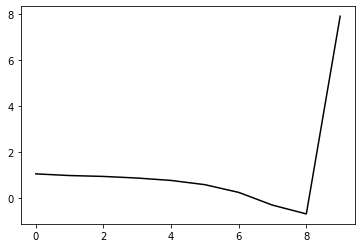

45000 0.20297087399424837
0.25009372768170457 -0.21242071793206527 -0.190106106082813 -0.13217590679803645
[ 1.02114426  1.03185635  1.01189747  0.94930653  0.83395869  0.63699047
  0.29785631 -0.25776179 -0.63999828  7.92549157]


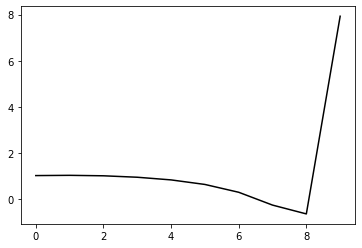

46000 0.2200248569499493
0.25083652903819553 -0.20501777977879718 -0.1872489184737729 -0.12883170820014136
[ 1.06561687  1.04692194  0.98001389  0.90073994  0.7897674   0.59789422
  0.25521149 -0.31000475 -0.70838053  7.93065036]


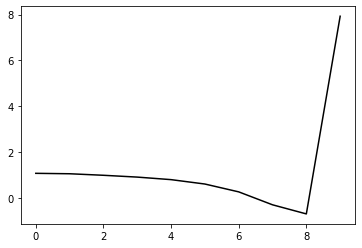

47000 0.20330060652939577
0.2479079860337706 -0.2081607566984533 -0.1896536290501876 -0.12911500835748463
[ 1.05485552  1.06572915  0.9602008   0.87141933  0.76596621  0.5774381
  0.23599556 -0.32782493 -0.72577229  7.91630691]


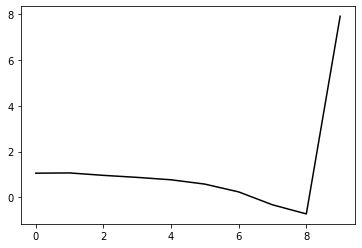

48000 0.19301781259960513
0.2516953134339248 -0.2058091360017773 -0.19045388938734215 -0.1292931479033612
[ 1.0775945   1.0518785   1.02861114  0.9673454   0.86473098  0.67924624
  0.34675508 -0.20896084 -0.60265617  7.94795836]


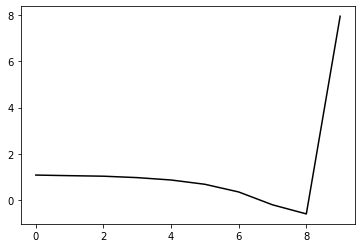

49000 0.21837205573893895
0.2500675729741125 -0.20563867391900756 -0.19094175263627589 -0.1298156923421364
[ 1.04920852  1.07939643  1.03696093  0.98150603  0.88154935  0.6940212
  0.35705476 -0.202472   -0.6028796   7.93270529]


50000 0.29129881097308463
0.2466640793106214 -0.20435644255349875 -0.19091175434372934 -0.12896489537442804
[ 1.07327527  1.05418861  1.00079022  0.93799387  0.84496588  0.66596321
  0.33285525 -0.22763683 -0.63242572  7.94602801]


51000 0.1653024683721809
0.25282413721636326 -0.20061655503720952 -0.18970900113294598 -0.1316790118113015
[ 1.0258739   1.03868034  1.03323645  0.97435263  0.84899758  0.63807488
  0.28508423 -0.29148601 -0.71253561  7.89977484]


52000 0.18513265053582964
0.2472572402115983 -0.20777317359519454 -0.19548732909856703 -0.1281751124729643
[ 0.98449786  0.92400604  0.88654403  0.82513499  0.7227277   0.53077957
  0.18150421 -0.39577115 -0.81774346  7.90320904]


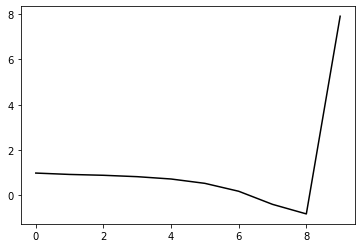

53000 0.21985182486451904
0.2504085039376243 -0.20079996738941996 -0.1920380874933401 -0.12917432755558925
[ 1.02614459  1.03141514  1.01852751  0.98153778  0.89020607  0.70028602
  0.3502331  -0.23427743 -0.66964129  7.91388302]


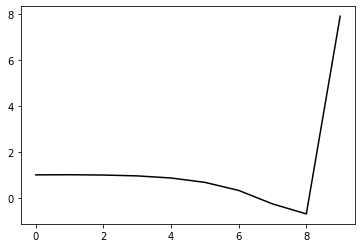

54000 0.2304178346449995
0.24782608763864233 -0.20159986766018886 -0.19363835044017036 -0.1274434376242537
[ 1.03200006  1.05892609  1.04068945  1.0003413   0.91680208  0.74303281
  0.40537151 -0.17772763 -0.61937592  7.92917568]


55000 0.20624403228428134
0.24685414407322687 -0.1963935059759951 -0.19062208613380097 -0.1280950410469511
[ 1.06096102  1.01356382  0.99454552  0.9411471   0.83200436  0.63473582
  0.28537474 -0.30400742 -0.75454995  7.90234382]


56000 0.1725466561045481
0.24525110012761286 -0.19451696647187283 -0.19061084173356815 -0.12582989085024876
[ 1.03568704  1.03658265  1.02649291  0.97811982  0.87414287  0.67523729
  0.31238384 -0.29563902 -0.77272195  7.91277644]


57000 0.22616889324644807
0.2406711273111368 -0.1983899951320326 -0.19323444715421573 -0.12667758696237522
[ 1.0006734   1.00643348  0.98517521  0.93378435  0.84362866  0.67321837
  0.33959584 -0.24770409 -0.71021986  7.91315674]


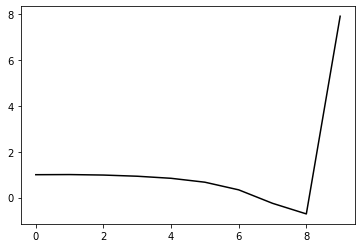

58000 0.1942622312723878
0.23231785477186206 -0.20219484017301564 -0.19510789090132083 -0.1264873211167624
[ 1.02270981  0.89481309  0.86861753  0.826537    0.73637335  0.56115936
  0.23330708 -0.34244844 -0.7990641   7.93139673]


59000 0.2237262843356847
0.23887504131952453 -0.19688921656997885 -0.19364896962148112 -0.12670544256172844
[ 1.00407089  1.10852847  1.07081015  1.00438671  0.90036362  0.7160883
  0.37931379 -0.20480382 -0.67876109  7.93532331]


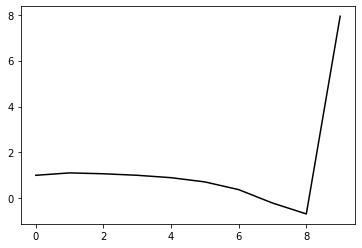

60000 0.29433608104039005
0.23360532901644973 -0.1932384973550765 -0.1920786600597257 -0.1267752382788424
[ 1.09488476  1.06770802  1.05192908  1.00768367  0.92100319  0.75026581
  0.42169757 -0.15707668 -0.63463104  7.93533585]


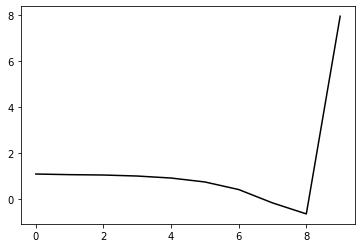

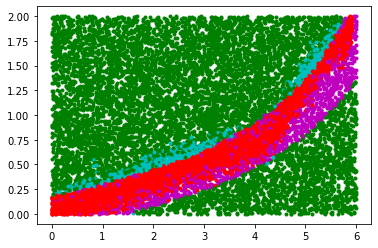

61000 0.2284951757562419
0.23194986461498765 -0.19638268672327167 -0.1949798397325425 -0.12369933106548672
[ 1.04670583  1.0092423   0.98012904  0.93470899  0.85610163  0.69606236
  0.37977347 -0.18734124 -0.65722251  7.90131035]


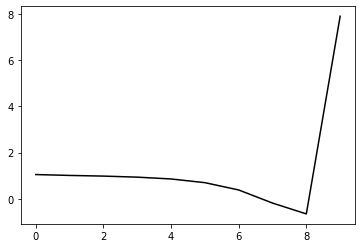

62000 0.20982342668860676
0.23341204410520228 -0.19905849416262303 -0.19822310675182434 -0.1211653487202553
[ 1.01169984  0.98822035  0.9469594   0.87736788  0.78711228  0.63432092
  0.33904638 -0.20179869 -0.64850138  7.98339065]


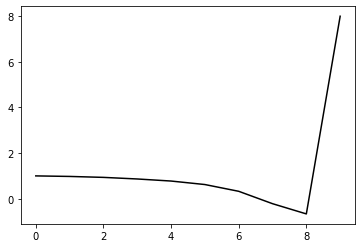

63000 0.16455997634507477
0.23286484473346172 -0.1984401645638462 -0.19694379688905858 -0.12362386001989875
[ 1.02530346  0.95788996  0.92653639  0.86708106  0.77398789  0.60482448
  0.2980463  -0.23570761 -0.66854821  7.93989621]


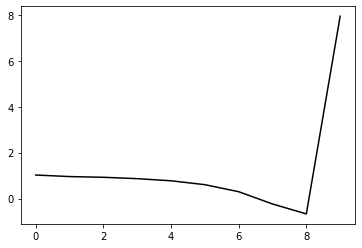

64000 0.3408473144155844
0.23732097628426269 -0.1913532586188328 -0.1923804369990206 -0.12654006118680136
[ 1.10360461  1.06538584  1.05081121  0.99127364  0.8795528   0.69133983
  0.36696444 -0.17665977 -0.61159259  7.94075826]


65000 0.26307804982497485
0.23581691334063443 -0.18913626674769304 -0.1924255334678181 -0.12576235380341644
[ 1.08297131  1.03735871  1.01734529  0.97554651  0.88958029  0.71306924
  0.38265306 -0.17124718 -0.60825071  7.94323721]


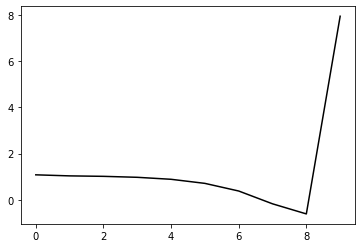

66000 0.22668857695781391
0.23765510958116134 -0.18976282863968363 -0.19312284477768232 -0.12584983734751742
[ 1.0496455   1.06522839  1.04607047  0.99599957  0.89739744  0.71509292
  0.38542251 -0.171256   -0.60249445  7.94609968]


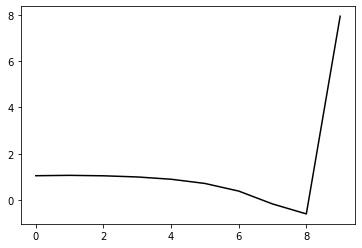

67000 0.2896779743398933
0.234122443006987 -0.18701268986749853 -0.19169537889183855 -0.12556163091401976
[ 1.10272059  1.03450097  1.01767676  0.95822809  0.85723739  0.68992807
  0.37843153 -0.16594216 -0.58640593  7.95142904]


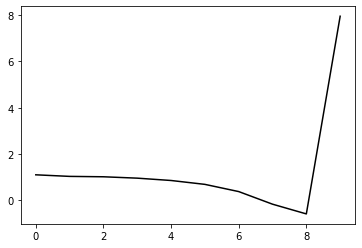

68000 0.27424653028897167
0.23516905077912897 -0.19626343484416583 -0.19787128552715932 -0.12324122215422746
[ 0.9950722   0.95697949  0.92605817  0.8679019   0.76773031  0.57953896
  0.25115962 -0.29621549 -0.71183212  7.93140128]


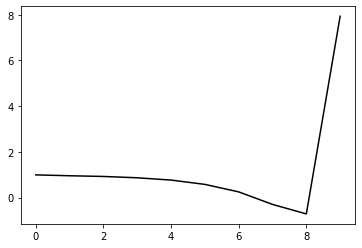

69000 0.2501379599989449
0.23541977049310941 -0.19173714766725486 -0.19445691758633887 -0.1266652503818211
[ 1.07868551  1.02552973  0.98209739  0.91583107  0.81177807  0.62288066
  0.28812428 -0.26477731 -0.68057933  7.92995801]


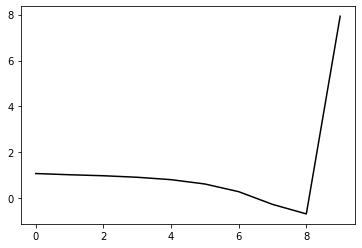

70000 0.2173626470891038
0.23848875381935916 -0.1929888622449763 -0.19464982747668685 -0.13151702977580604
[ 1.02196719  1.01399391  0.98998686  0.93535716  0.83704649  0.65415357
  0.32044709 -0.23159483 -0.63577503  7.91928484]


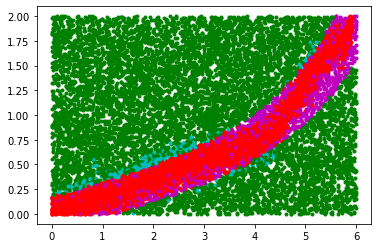

71000 0.16658286732697627
0.24078147178314688 -0.19195176771780764 -0.194543387693264 -0.13057164320752693
[ 1.00643882  1.09006905  1.06128476  0.99334286  0.87856728  0.68922829
  0.35871707 -0.19158229 -0.59156891  7.92797477]


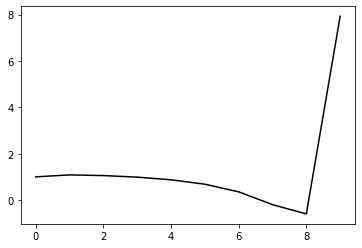

72000 0.22543424375297155
0.23756534315300454 -0.19524766218463746 -0.19715263751223994 -0.1271448741757638
[ 0.99427006  0.9525001   0.9102697   0.84199581  0.73787261  0.54733552
  0.20928943 -0.34699639 -0.75029222  7.92181554]


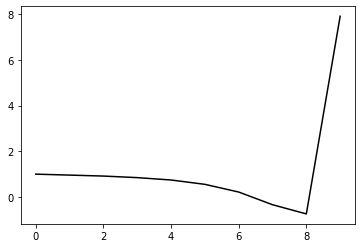

73000 0.2380305174278242
0.23587813243101866 -0.1943659799470629 -0.19734526805911226 -0.12880042771257752
[ 1.07437743  0.95913509  0.93950519  0.90336594  0.8151981   0.63271106
  0.2966886  -0.26353077 -0.67222342  7.92935007]


74000 0.2700595481613169
0.233391258399081 -0.1874223620767229 -0.19366015853520518 -0.12749001184224404
[ 1.0943882   1.0418041   1.0024559   0.9473345   0.86046843  0.69085058
  0.36416276 -0.19761242 -0.61410294  7.94316605]


75000 0.14087528425102555
0.23185339885155307 -0.19248484026359772 -0.1963219209592647 -0.12700950923952223
[ 1.06861165  0.99189253  0.97127699  0.92317912  0.82820821  0.64889148
  0.32084572 -0.23766697 -0.64972328  7.9325135 ]


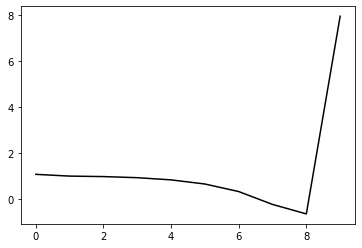

76000 0.17840032594183286
0.23477402472577508 -0.18939632410101506 -0.19493458518249446 -0.1282414208950682
[ 1.03952269  1.10505846  1.06986403  0.99481513  0.8798837   0.68956777
  0.35343223 -0.21086987 -0.62937743  7.92116799]


77000 0.1690286922243576
0.23208722944573318 -0.18901543257295159 -0.1947411480903418 -0.1299279095526685
[ 1.04335566  1.01219613  0.99251818  0.94690411  0.86007594  0.68532331
  0.35762023 -0.19616991 -0.60340554  7.89619205]


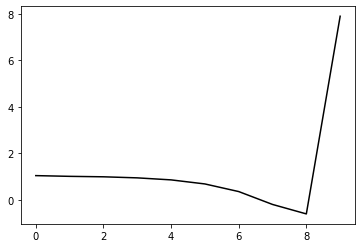

78000 0.21195479148374927
0.23251529972510274 -0.18613934983898128 -0.19477691513266857 -0.12584115277346788
[ 1.03803142  1.06714158  1.03392513  0.95976685  0.85223927  0.67702269
  0.3570676  -0.19496203 -0.60640624  7.93396764]


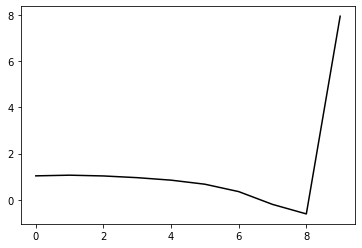

79000 0.1504626420915524
0.22674575982027656 -0.19161553569428788 -0.19735279177779314 -0.12513176490961564
[ 1.03349786  1.00190484  0.97526146  0.91962738  0.82334786  0.64045455
  0.30977558 -0.24776507 -0.66713997  7.94374996]


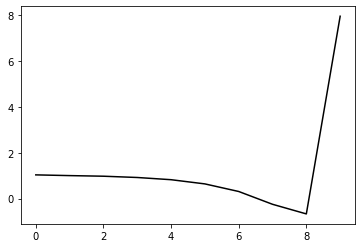

80000 0.23133921496039203
0.23169560029064898 -0.18781143904901065 -0.1958186477936062 -0.12494998177489396
[ 1.0347229   1.07642524  1.07206117  1.03896969  0.95031876  0.76222663
  0.41685365 -0.15748194 -0.59396203  7.92225076]


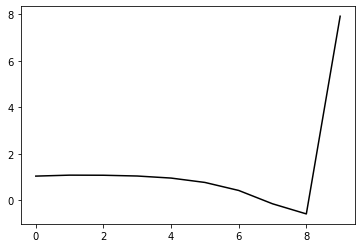

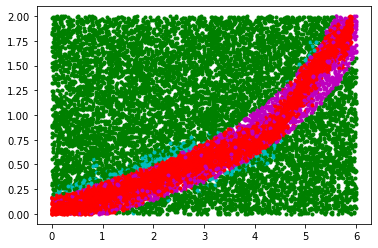

81000 0.20022796330661655
0.22861497695000116 -0.1864362433967726 -0.19433113039245345 -0.12473005760597457
[ 1.07138825  1.01634705  0.97726754  0.93085021  0.83770548  0.65410822
  0.31101313 -0.26839537 -0.70893474  7.88933196]


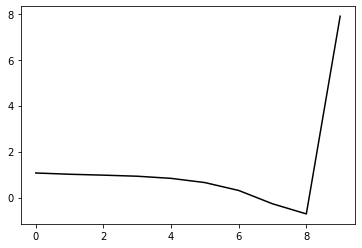

82000 0.2133163427722675
0.22703545358603644 -0.18774155241151402 -0.19661166241672015 -0.12294389534661967
[ 1.10997726  1.02696857  0.97800293  0.92531459  0.84093344  0.67785207
  0.35788901 -0.20576934 -0.63778974  7.96723968]


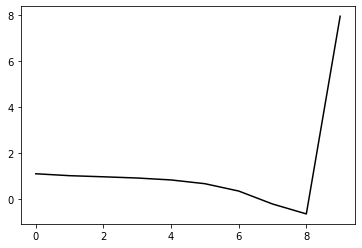

83000 0.28168472512711235
0.2325360292651525 -0.1910947626655079 -0.20070855144212565 -0.1196676415081012
[ 1.00719321  0.98417684  0.95939757  0.90153549  0.80853731  0.62787638
  0.29719549 -0.26817147 -0.70281472  7.95688645]


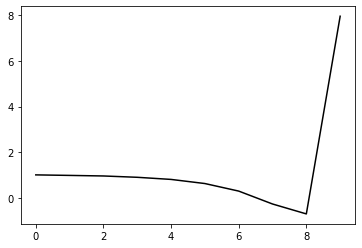

84000 0.2549944943193375
0.23389118426000366 -0.1840081056980479 -0.19617785213123953 -0.1220355944668642
[ 1.03565196  1.09436413  1.08422205  1.03757789  0.94154437  0.75703022
  0.41918994 -0.15312238 -0.59758935  7.93815685]


85000 0.2590015095616212
0.22979035373449375 -0.19194427230961178 -0.2004716644642523 -0.1238570321798773
[ 1.00163154  0.93689784  0.91116154  0.87061386  0.78414254  0.60737513
  0.2743682  -0.29389068 -0.73164563  7.94043642]


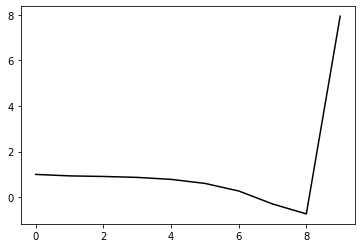

86000 0.13142258251982494
0.23242156946337314 -0.18765990177386146 -0.19807057871406897 -0.12710316416692502
[ 1.04776514  1.09525598  1.05933881  1.00987908  0.91730795  0.7376343
  0.40364755 -0.16886991 -0.61532056  7.93294544]


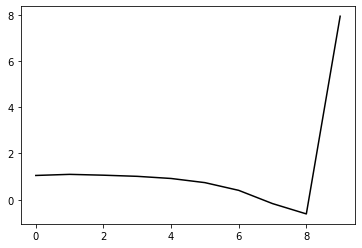

87000 0.2606644290739957
0.22649105067264663 -0.18692883779702704 -0.19592541283684853 -0.12845870790569602
[ 1.0853488   0.97690056  0.87425743  0.8038958   0.7103354   0.53273284
  0.19971111 -0.37118218 -0.81586978  7.90496231]


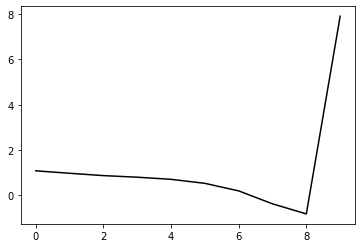

88000 0.2386451158694311
0.23341387192534457 -0.18494315264938593 -0.19568619855026745 -0.1314896977985661
[ 1.07300087  1.02748732  0.99225749  0.93711932  0.83251605  0.63888095
  0.29756952 -0.27555981 -0.71929525  7.91880583]


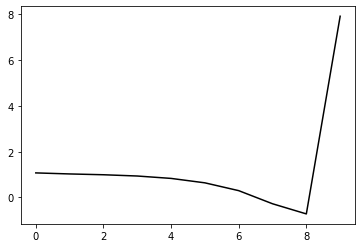

89000 0.21248745329653132
0.23101517122696466 -0.18536631178599344 -0.19685324143922328 -0.1294075305999884
[ 1.05227007  1.02430666  0.98995423  0.92537736  0.82480642  0.64382034
  0.30713234 -0.26793611 -0.7165791   7.95394806]


90000 0.2729836171893493
0.2355565346759146 -0.18407327434662787 -0.1987337644576521 -0.12686201280083576
[ 1.06440058  1.04052873  1.03053765  0.98960481  0.90106733  0.72661321
  0.39678152 -0.17386234 -0.62367861  7.92333997]


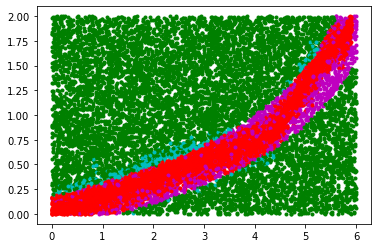

91000 0.142100150225855
0.23556940734955448 -0.18219254251191414 -0.19858555961653 -0.12568852084801987
[ 1.02887363  1.07674597  1.04377723  0.99348889  0.90795657  0.74598074
  0.43403516 -0.11944322 -0.55704694  7.9396231 ]


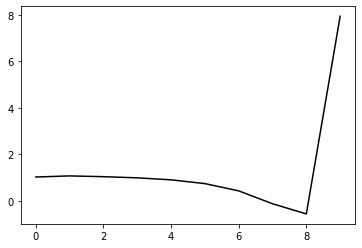

92000 0.2524254255015942
0.237363169084983 -0.18005692355895364 -0.19724992318057485 -0.12673072463556667
[ 1.0760133   1.04415879  1.02313076  0.97304896  0.87131975  0.68266888
  0.34912533 -0.21486237 -0.65896147  7.94546011]


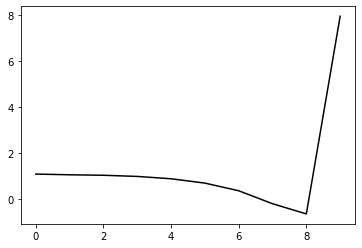

93000 0.12764602472374853
0.23036726197148846 -0.18562295651859395 -0.19953916111744388 -0.1274082754353815
[ 1.04251826  1.01169112  0.97671138  0.91845197  0.82502563  0.65208893
  0.32905598 -0.22280628 -0.64689627  7.95751919]


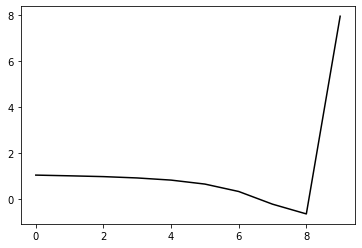

94000 0.2199385658223228
0.23627222655627797 -0.18135506449124833 -0.1977723088044838 -0.12690877027898595
[ 1.06463666  1.02792761  1.01924595  0.96834906  0.86305052  0.67243657
  0.34035179 -0.21472124 -0.63744273  7.91038328]


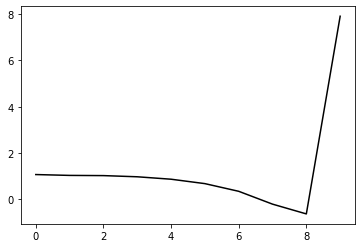

95000 0.18464742933961092
0.2401793409114383 -0.1805211772339027 -0.19720417157664483 -0.1276048570744056
[ 1.08358488  1.04717305  1.03964718  0.9852632   0.87394863  0.68017218
  0.34027054 -0.22215366 -0.64821006  7.98447996]


96000 0.2457036559569306
0.24157377949042658 -0.1792537658528306 -0.19690045256162086 -0.12578594956732783
[ 1.08223714  1.07567172  1.07379464  1.0114071   0.88168967  0.66746103
  0.30813864 -0.27213321 -0.70846473  7.90584312]


97000 0.22576701828695428
0.23845063017940146 -0.18116162815493267 -0.19754524160679657 -0.12821411549123385
[ 1.10137319  1.06856371  1.04565956  0.99997153  0.90106927  0.70311854
  0.34404102 -0.24145327 -0.67554279  7.93163637]


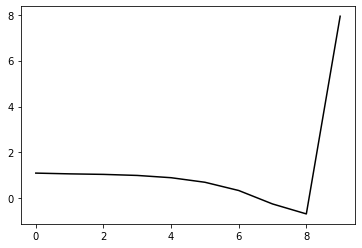

98000 0.20043816508646775
0.24182819750292953 -0.18009911759981634 -0.19703977818977494 -0.1276128912095842
[ 1.04172422  1.07023599  1.0657625   1.0094559   0.90094157  0.7055956
  0.35189102 -0.23673232 -0.67451172  7.90746253]


99000 0.29569099236634155
0.23492454297466747 -0.18812525417459655 -0.20130081907630842 -0.1258422275250889
[ 0.98768486  0.93601896  0.9040948   0.83605424  0.72729649  0.5400119
  0.20086816 -0.37465907 -0.80211039  7.91056874]


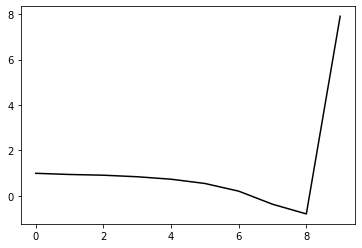

In [19]:
optimizer=tf.optimizers.Adam(learning_rate=0.0005)
for j in range (10000):    
    with tf.GradientTape() as g:
        loss=Error_func(h, m2, lam, alpha, beta, Positive[j%set], Negative[j%set])
        gradients=g.gradient(loss, [h, m2, lam, alpha, beta])
        if np.isnan(loss)==True: break
    for i in range (90):
        optimizer.apply_gradients(zip(gradients, [h]))
        if any(np.isnan(h.numpy()))==True: break
    for i in range (10):
        optimizer.apply_gradients(zip(gradients, [h, m2, lam, alpha, beta]))
        if any(np.isnan(h.numpy()))==True: break
    if j%100==0: 
        print(j*10, Error_func(h, m2, lam, alpha, beta, Positive[np.int32((j/set)%set)], Negative[np.int32((j/set)%set)]).numpy())
        print(m2.numpy(), lam.numpy(), alpha.numpy(), beta.numpy()), print(h.numpy())
        plt.plot(h.numpy(), 'k-'), plt.show()
    if j%1000==0:
        for i in range (set):
            [Positive0[i], Positive1[i]]=NN_func_01(h, m2, lam, alpha, beta, Positive[i])
            [Negative0[i], Negative1[i]]=NN_func_01(h, m2, lam, alpha, beta, Negative[i])
        for i in range (set):
            x_data1[i]=[v[0] for v in Positive0[i]]
            y_data1[i]=[v[1] for v in Positive0[i]]
            x_data2[i]=[v[0] for v in Positive1[i]]
            y_data2[i]=[v[1] for v in Positive1[i]]
            x_data3[i]=[v[0] for v in Negative0[i]]
            y_data3[i]=[v[1] for v in Negative0[i]]
            x_data4[i]=[v[0] for v in Negative1[i]]
            y_data4[i]=[v[1] for v in Negative1[i]]
            plt.plot(x_data4[i], y_data4[i], 'g.')
            plt.plot(x_data2[i], y_data2[i], 'c.')
            plt.plot(x_data1[i], y_data1[i], 'r.')
            plt.plot(x_data3[i], y_data3[i], 'm.')
        plt.show()

In [22]:
for i in range (set):
    [Positive0[i], Positive1[i]]=NN_func_01(h, m2, lam, alpha, beta, Positive[i])
    [Negative0[i], Negative1[i]]=NN_func_01(h, m2, lam, alpha, beta, Negative[i])
for i in range (set):
    x_data1[i]=[v[0] for v in Positive0[i]]
    y_data1[i]=[v[1] for v in Positive0[i]]
    x_data2[i]=[v[0] for v in Positive1[i]]
    y_data2[i]=[v[1] for v in Positive1[i]]
    x_data3[i]=[v[0] for v in Negative0[i]]
    y_data3[i]=[v[1] for v in Negative0[i]]
    x_data4[i]=[v[0] for v in Negative1[i]]
    y_data4[i]=[v[1] for v in Negative1[i]]
    plt.plot(x_data4[i], y_data4[i], 'g.')
    plt.plot(x_data2[i], y_data2[i], 'c.')
    plt.plot(x_data1[i], y_data1[i], 'r.')
    plt.plot(x_data3[i], y_data3[i], 'm.')
plt.show()

99990 0.23298604685787017
0.23528895365995944 -0.1866579043184102 -0.20112272394844316 -0.12562366835718242
[ 1.03708384  1.03710603  1.01586872  0.96430303  0.86412774  0.67420311
  0.33047191 -0.24758244 -0.681338    7.95561093]


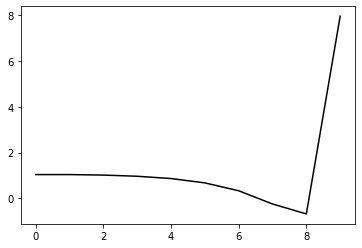

([<matplotlib.lines.Line2D at 0x2c8eca9e248>], None)

In [26]:
print(j*10, Error_func(h, m2, lam, alpha, beta, Positive[np.int32((j/set)%set)], Negative[np.int32((j/set)%set)]).numpy())
print(m2.numpy(), lam.numpy(), alpha.numpy(), beta.numpy()), print(h.numpy())
plt.plot(h.numpy(), 'k-'), plt.show()